<a href="https://colab.research.google.com/github/francescomazzolin/stochastic-finance-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Finance Project

Giada Martini

Francesco Mazzolin

Francesco Salvagnin

Nicolas Stecca


### Outline

1) **Data retrieval and preprocessing:**

In this part we will retrieve first a cross-section snapshot of the S&P 500 companies, including their equity-value, debt, sector etc.. from which we compute a first proxy of the companies' asset value as the sum of the value of debt plus the closing price times the number of shares used to compute the Diluted EPS multiple.

Using sector information we drop companies belonging to the Financial & Insurance companies. 

We then use this data to group the companies according to a leverage ratio computed with total debt over the value of the asset using the K-Means clustering algorithm to obtain four different groups according to this metric. For each of these groups we will sample 5 companies.

For this sample of 20 companies, we will then retrieve historical data from which we will compute a rolling-window estimate of the daily equity value volaitlity, in addition to compute again a rough estimate of the value of the asset across time. 



2) **Computing the value of the asset and its volatility:**

We compute the value of the asset and its volaitlity using the procedure in Afik, Arad, Galil (2013), which involves a numerical procedure to solve a non-linear system of equations. 

3) **Computing the relevant quantities of the Merton's model:**

We proceed to compute the output of the Merton's model which include: 

- The real-world probability of default. 

- The value of the equity under the risk-neutral measure

- The value of the debt under the risk-neutral measure. 

- The credit spread

In addition we provide plots to assess the impact of the leverage ratio and assets' volatility on both the probability of default and the credit spread, plus we assess the impact of maturity on the credit spread.

4) **Monte Carlo simulations of the probability of default:** 

We compute the Monte Carlo approximation of the probability of default and show the goodness of this approximation, presenting also a plot for the Random Walk paths evolution compared to the Default Threshold.

5) **Extensions of the Merton's model:** 

We compyte the probability of default postulating that the assets' value process follows a Jump process rather than the standard process



## 1) Data retrieval and preprocessing


In [77]:
#For Google Colab use
#!pip install eikon


import eikon as ek
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import importlib
import matplotlib.pyplot as plt

#User-defined functions
import plotting_functions as mp
import analytical_functions as af
import data_retrieval as dr

#importlib.reload(af)

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


### Retrieving the data

In [78]:
# Setting up the API key
ek.set_app_key('86872e92eb6d46a0a1b182488b3c6bff38c6b468')


#### Search parameters

These include:

- The fields that we will retrieve for each company

- The time range for which we will retrieve such data

- The annualization coefficient


In [79]:
fields = ['TR.CLOSEPRICE.date',
            'TR.CLOSEPRICE', 
            'TR.F.ShrUsedToCalcDilEPSTot','TR.F.MktCap', 'TR.F.DebtTot',
            'TR.CommonName', 'TR.NAICSSector']

start_date = '2024-12-30'

end_date = '2018-12-30'

rolling_window = 252

The **random** parameter allows for the script to retrieve and choose 20 random companies from the S&P 500 (excluding financial & insurance companies).

If it is set to false, then it will use a sample of 20 companies for which the analysis is meant to be done upon.

In [80]:
random = False
if not random:

    rics_list = ['AEP.OQ', 'VTRS.OQ', 'EVRG.OQ', 'EIX.N', 'KMX.N', 'ED.N', 'DAL.N', 'SO.N', 'T.N', 'AMCR.N', 'GNRC.N', 
                'PM.N', 'FOXA.OQ', 'BFb.N', 'NEM.N', 'DOV.N', 'ZBRA.OQ', 'WST.N', 'EOG.N', 'PANW.OQ']
    
else:

    rics_list = ['0#.SPX']

In [81]:
#This will get all the stocks in the S&P 500 data_cross for the specified fields
data_cross, err = ek.get_data(instruments= rics_list, fields = fields)
data_cross.head()

number = data_cross.shape[0]

#Excluding financial sector
data_cross = data_cross[data_cross['NAICS Sector Name'] != 'Finance and Insurance']
post_number = data_cross.shape[0]

print(f'Removed {number - post_number} companies, for a total of {data_cross.shape[0]} companies')

Removed 0 companies, for a total of 20 companies


### Getting different groups of stocks based on their leverage ratio

We will use, at this stage, as a proxy of the value of the assets the sum of the market capitalization of a given firm and the firm's total debt.

We will then use this proxy to compute a leverage ratio and according to its value we will group the companies into different groups.

In [82]:
data_cross['Equity Value'] = data_cross['Close Price'] * data_cross['Shares used to calculate Diluted EPS - Total']

data_cross['Asset Value'] = data_cross['Equity Value'] + data_cross['Debt - Total']

data_cross['Leverage Ratio'] = data_cross['Debt - Total'] / data_cross['Asset Value']

data_cross = data_cross.sort_values(by = 'Leverage Ratio', ascending= False)

data_cross = data_cross.dropna(subset=['Leverage Ratio'])

print(data_cross.head())

  Instrument                  Date  Close Price  \
4      KMX.N  2025-01-06T00:00:00Z        79.75   
1    VTRS.OQ  2025-01-06T00:00:00Z        11.95   
3      EIX.N  2025-01-06T00:00:00Z        78.44   
2    EVRG.OQ  2025-01-06T00:00:00Z        60.27   
0     AEP.OQ  2025-01-06T00:00:00Z        90.32   

   Shares used to calculate Diluted EPS - Total  Market Capitalization  \
4                                     158707000          12451343181.0   
1                                    1206900000         12990936920.85   
3                                     385000000     27421327292.369999   
2                                     230500000     11990452438.799999   
0                                     520206258     42711651075.379997   

   Debt - Total                  Company Common Name NAICS Sector Name  \
4   18976741000                           Carmax Inc      Retail Trade   
1   18131500000                          Viatris Inc     Manufacturing   
3   34090000000           

In [83]:
#Check to see that the companies are ranked by Leverage Ratio in decreasing order
print(data_cross[['Company Common Name', 'Leverage Ratio']].head(100))

                    Company Common Name  Leverage Ratio
4                            Carmax Inc        0.599891
1                           Viatris Inc        0.556968
3                  Edison International        0.530258
2                            Evergy Inc        0.487259
0   American Electric Power Company Inc        0.478894
8                              AT&T Inc        0.455701
5               Consolidated Edison Inc        0.442164
7                           Southern Co        0.410884
6                   Delta Air Lines Inc         0.34187
9                             Amcor PLC        0.330201
12                             Fox Corp        0.232016
14                  Newmont Corporation        0.228932
11      Philip Morris International Inc        0.203157
13                    Brown-Forman Corp        0.149898
10                 Generac Holdings Inc        0.136877
15                           Dover Corp        0.115998
16              Zebra Technologies Corp        0

#### Clustering the stocks based on their leverage ratio

We have chosen to cluster them into 4 groups based on a quick-and-dirty implementation of the K-Means clustering algorithm.

The idea is to group them into the following categories:

- High

- Medium-high

- Medium-low

- Low 

According to the level of their leverage ratio compared to the rest of the stocks in the index

In [84]:
# Cluster them

n_clusters = 4

if random:
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score



    scaler = MinMaxScaler()
    data_cross['leverage_ratio_normalized'] = scaler.fit_transform(data_cross[['Leverage Ratio']])

    silhouette_scores = []
    for k in range(2, 11):  # Start from 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_cross[['leverage_ratio_normalized']])
        silhouette_scores.append(silhouette_score(data_cross[['leverage_ratio_normalized']], labels))

    # Plot silhouette scores
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data_cross[['leverage_ratio_normalized']])
    # Add cluster labels to the data_crossFrame
    data_cross['cluster'] = labels
    cluster_means = data_cross.groupby('cluster')['Leverage Ratio'].mean()

    ranked_clusters = cluster_means.sort_values(ascending=False).rank(ascending=False).astype(int)

    # Step 3: Map ranked cluster numbers back to the data_crossFrame
    ranked_mapping = {cluster: rank for cluster, rank in zip(cluster_means.sort_values(ascending=False).index, ranked_clusters)}
    data_cross['ranked_cluster'] = data_cross['cluster'].map(ranked_mapping)

    print(data_cross[['Leverage Ratio', 'cluster', 'ranked_cluster']])

    print('\nThe companies for each cluster are:')
    data_cross['ranked_cluster'].value_counts()

else: 

    data_cross['ranked_clusters'] = np.repeat(range(1, n_clusters + 1), len(data_cross) // n_clusters)

cluster_dict = {

    1 : 'High',
    2: 'Medium-high',
    3: 'Medium-low',
    4: 'Low'

}

It is at this stage that the random sampling of 20 companies, 5 for each cluster, is performed.

In [85]:
if random:
    # Sample 5 companies from each cluster
    sampled_data = data_cross.groupby('ranked_cluster').apply(lambda x: x.sample(n=5, random_state=42))

    # Reset index to make it easier to work with
    sampled_data = sampled_data.reset_index(drop=True)

    print(sampled_data.sort_values(by = 'Leverage Ratio', ascending = False))

else:

    sampled_data = data_cross.sort_values(by = 'Leverage Ratio', ascending = False) 

random_sample = list(sampled_data['Instrument'])

print(random_sample)

['KMX.N', 'VTRS.OQ', 'EIX.N', 'EVRG.OQ', 'AEP.OQ', 'T.N', 'ED.N', 'SO.N', 'DAL.N', 'AMCR.N', 'FOXA.OQ', 'NEM.N', 'PM.N', 'BFb.N', 'GNRC.N', 'DOV.N', 'ZBRA.OQ', 'EOG.N', 'PANW.OQ', 'WST.N']


### Retrieve **time-series** data

Then we retrieve time-series data for these 20 companies and, based on this data, we compute.

- The Market Equity Value by multiplying the closing stock's price by the number of shares used to calculate the Diluted EPS multiple.

- The logarithmic returns for each stock in the sample.

- According to these returns, we compute a rolling-window estimator of the daily volatility of the stock, which implies that we will **drop a number of observations equal to that of the rolling window**.


We then concatenate these values for each stock in a multi-index dataframe, with first index being the RIC identifier for the stock and the second one being the date.

In [86]:
#We remove fields that were only useful in the cross-section case above
removing_fields = ['TR.CommonName', 'TR.NAICSSector']

fields = [i for i in fields if i not in removing_fields]

#### Retrieving the data

In [87]:
data = dr.get_financial_data(rics_list, fields,
                          start_date, end_date,
                          252)

print(data.head())

print('-'*100)

print(data.tail())

print('-'*100)
#Checks on single stocks
print(data.loc[rics_list[0]].head())

print('-')
print(data.loc[rics_list[1]].describe())

     Instrument                  Date  Close Price  \
0        AEP.OQ  2024-12-30T00:00:00Z        92.06   
1        AEP.OQ  2024-12-27T00:00:00Z        92.51   
2        AEP.OQ  2024-12-26T00:00:00Z        92.06   
3        AEP.OQ  2024-12-24T00:00:00Z        92.37   
4        AEP.OQ  2024-12-23T00:00:00Z        92.86   
...         ...                   ...          ...   
1505     AEP.OQ  2019-01-07T00:00:00Z        73.03   
1506     AEP.OQ  2019-01-04T00:00:00Z        73.44   
1507     AEP.OQ  2019-01-03T00:00:00Z        72.77   
1508     AEP.OQ  2019-01-02T00:00:00Z        72.94   
1509     AEP.OQ  2018-12-31T00:00:00Z        74.74   

      Shares used to calculate Diluted EPS - Total  Market Capitalization  \
0                                        520206258     42711651075.379997   
1                                        520206258     42711651075.379997   
2                                        520206258     42711651075.379997   
3                                        52

In [88]:
# Creating a RICS dictionary

index = data.index
unique_instruments = index.get_level_values('Instrument').unique()
print(unique_instruments)
print(len(unique_instruments))

unique_names = []

for ric in unique_instruments:

    row = data_cross[data_cross['Instrument'] == ric]
    
    name = row['Company Common Name'].iloc[0]
    unique_names.append(name)


print(unique_names)
#rics_dict = {key, value for key,value in unique_values}

rics_dict = {key:value for key,value in zip(unique_instruments, unique_names)}

Index(['AEP.OQ', 'VTRS.OQ', 'EVRG.OQ', 'EIX.N', 'KMX.N', 'ED.N', 'DAL.N',
       'SO.N', 'T.N', 'AMCR.N', 'GNRC.N', 'PM.N', 'FOXA.OQ', 'BFb.N', 'NEM.N',
       'DOV.N', 'ZBRA.OQ', 'WST.N', 'EOG.N', 'PANW.OQ'],
      dtype='string', name='Instrument')
20
['American Electric Power Company Inc', 'Viatris Inc', 'Evergy Inc', 'Edison International', 'Carmax Inc', 'Consolidated Edison Inc', 'Delta Air Lines Inc', 'Southern Co', 'AT&T Inc', 'Amcor PLC', 'Generac Holdings Inc', 'Philip Morris International Inc', 'Fox Corp', 'Brown-Forman Corp', 'Newmont Corporation', 'Dover Corp', 'Zebra Technologies Corp', 'West Pharmaceutical Services Inc', 'EOG Resources Inc', 'Palo Alto Networks Inc']


In [89]:
# import pickle
# import sys
# import os

# current_directory = os.getcwd()

# # Add the current working directory to sys.path
# if current_directory not in sys.path:
#     sys.path.append(current_directory)
#     print('Yes')


# with open('dataframe.pkl', mode= 'rb') as f:

#     data = pickle.load(f)

## 2) Computing the value of the asset and its volatility

These are the two key parameters of the Merton's model.

As they are not directly observable from market data, we used the approximation approach used in Afik, Arad, Galil (2013) of numerically solve a system of non-linear equations.

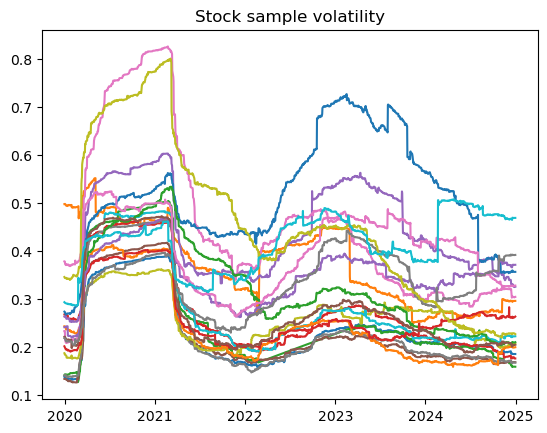

In [90]:
for ric in rics_list:

    plt.plot(data.loc[ric]['Rolling_Volatility'])
    plt.title('Stock sample volatility')

In [91]:
#Solve the system for each row
def solve_system(row):
    # Extract parameters from the row
    E = row['Equity_Value']
    sigma_E = row['Rolling_Volatility']  
    D = row['Debt - Total']
    
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']        
    
    #Time to maturity and current time
    T = 1                             
    t = 0                            

    #Define the system of equations
    def system(vars):
        if D > 0:
            A, sigma_A = vars  # Unknowns: Asset value and asset volatility
            equity_value = af.merton_equity(A, D, r, sigma_A, T, t)
            d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
            f1 = equity_value - E  # Equation (2)
            f2 = (A / E) * norm.cdf(d1) * sigma_A - sigma_E  # Equation (4)

        else: 

            f1 = E 
            f2 = sigma_E
        return [f1, f2]

    """
    As initial guesses we will use:

        - For the value of the asset the sum of the debt and the market value of the equity-

        - For the asset's volatility, the equity's volatility.
    """
    A_guess = row['Total_value']  
    sigma_A_guess = row['Rolling_Volatility'] 

    #Solve the system
    solution = fsolve(system, [A_guess, sigma_A_guess])
    return pd.Series({'A_solution': solution[0], 'sigma_A_solution': solution[1]})

#Apply the solver to the dataframe for vectorized execution
def solve_for_all(df):
    results = df.apply(solve_system, axis=1)
    return pd.concat([df, results], axis=1)


In [92]:
#Check to see whether there are still any NaNs
data.isna().sum()

Close Price                                     0
Shares used to calculate Diluted EPS - Total    0
Market Capitalization                           0
Debt - Total                                    0
RIC                                             0
Equity_Value                                    0
Log_Returns                                     0
Rolling_Volatility                              0
Total_value                                     0
dtype: int64

In [93]:
#Computing the asset value and volatility at each point in time

#For 20 companies it should take approximately 1 min 
df_with_solutions = solve_for_all(data)
print(df_with_solutions.head())

                                      Close Price  \
Instrument Date                                     
AEP.OQ     2019-12-31 00:00:00+00:00        94.51   
           2020-01-02 00:00:00+00:00        93.46   
           2020-01-03 00:00:00+00:00        93.36   
           2020-01-06 00:00:00+00:00        93.67   
           2020-01-07 00:00:00+00:00        93.69   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AEP.OQ     2019-12-31 00:00:00+00:00                                   493758277.0   
           2020-01-02 00:00:00+00:00                                   493758277.0   
           2020-01-03 00:00:00+00:00                                   493758277.0   
           2020-01-06 00:00:00+00:00                                   493758277.0   
           2020-01-07 00:00:00+00:00                                   493758277.0   

                         

In [94]:
#Adding leverage ratio computed by dividing the debt by the newly-computed value of the assets. 

df_with_solutions['Leverage_Ratio'] = df_with_solutions['Debt - Total'] / df_with_solutions['A_solution']

## 3) Computing the relevant quantities of the Merton's model

These are:

- The real-world probability of default. 

- The value of the equity under the risk-neutral measure

- The value of the debt under the risk-neutral measure. 

- The credit spread

In [95]:
def compute_additional_metrics(row):
    #Extract inputs from the row

    """
    V = row['Total_value']  # Asset value
    sigma = row['Rolling_Volatility']  # Asset volatility
    """
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    K = row['Debt - Total']  

    row['Risk_Free_Rate'] = 0.01
    r = row['Risk_Free_Rate']

    #Time to maturity and current time
    T = 1  
    t = 0  


    #Compute quantities using the provided functions
    equity_value = af.merton_equity(V, K, r, sigma, T, t)
    debt_value = af.merton_debt(V, K, r, sigma, T, t)
    default_probability = af.default_probability(V, K, r, sigma, T, t)
    
    credit_spread = af.credit_spread_model(V, K, sigma, r, T, t)

    #Return results as a pandas.Series
    return pd.Series({
        'Merton_Equity_Value': equity_value,
        'Merton_Debt_Value': debt_value,
        'Default_Probability': default_probability,
        'Credit_Spread': credit_spread
        
    })


In [96]:
"""
Computing the relevant quantities for each date.
"""

importlib.reload(af)

#Compute the equity value, debt value and probability of default for each company and at each date
#For 20 companies it should take approximately 40 sec
df_with_metrics = df_with_solutions.apply(compute_additional_metrics, axis=1)

#Combine the quantities results with the original dataframe
df_final = pd.concat([df_with_solutions, df_with_metrics], axis=1)

### Plotting the **probability of default** through time as a function of the leverage ratio and volatility

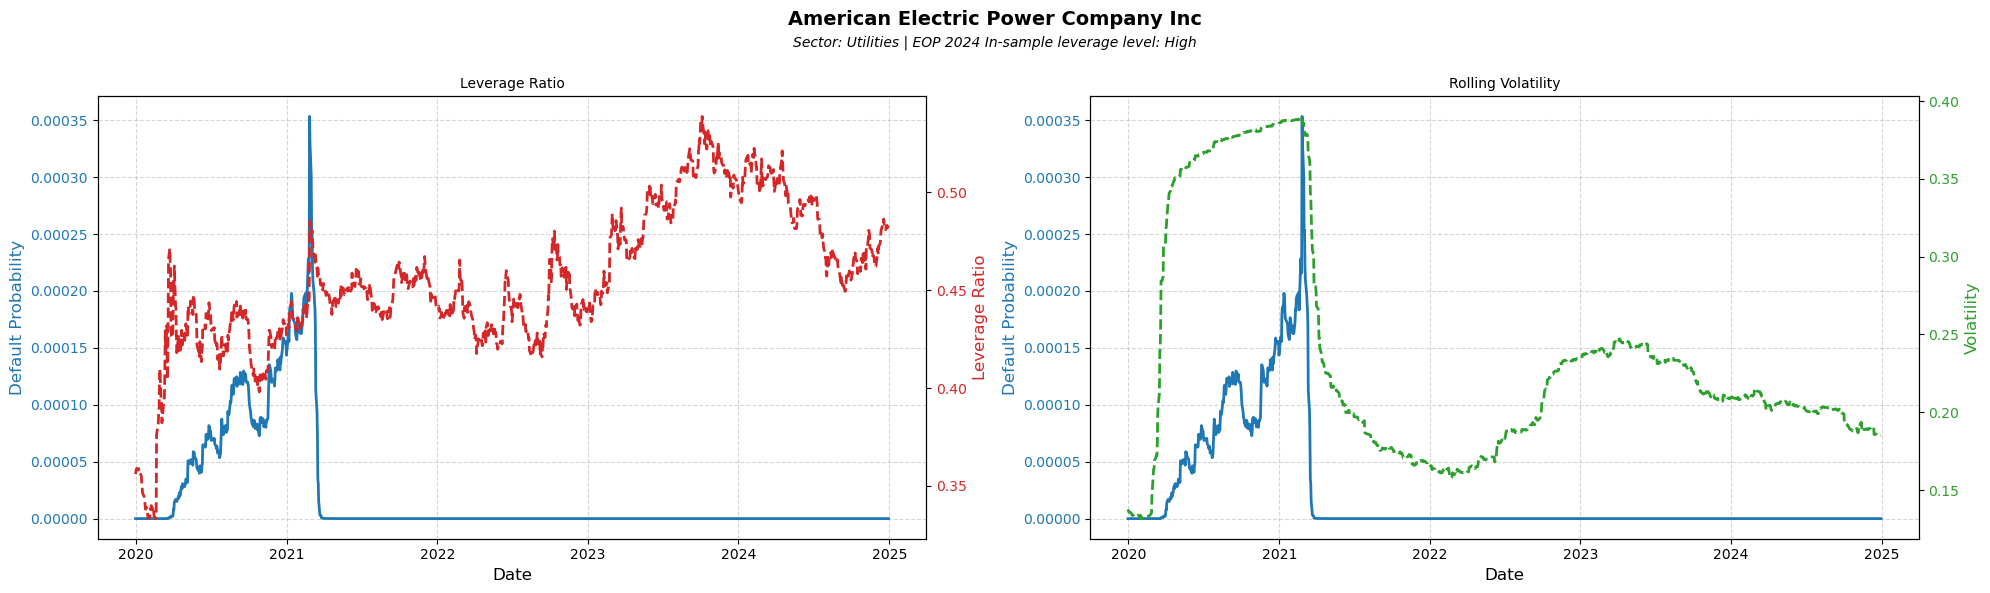

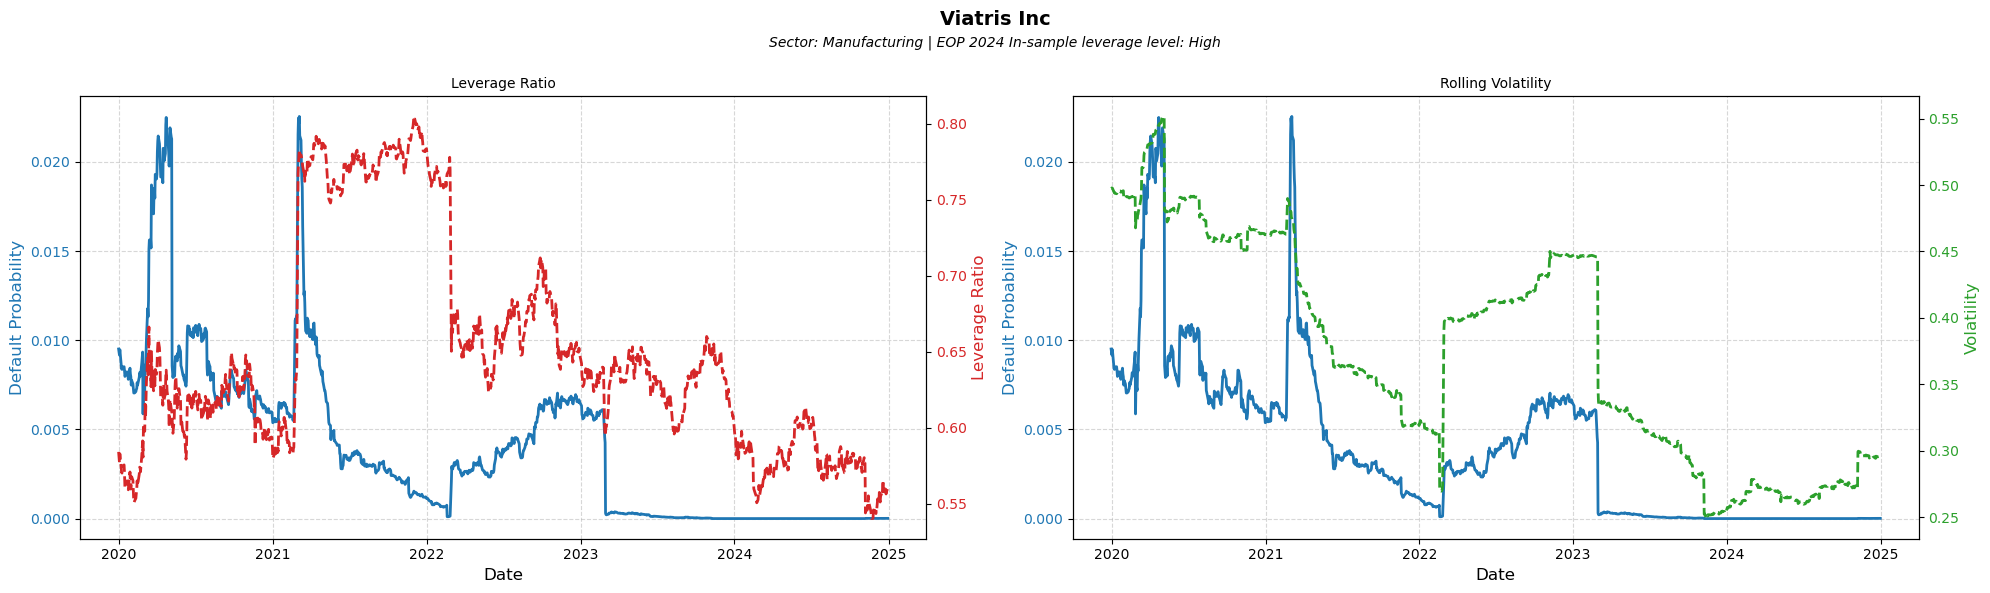

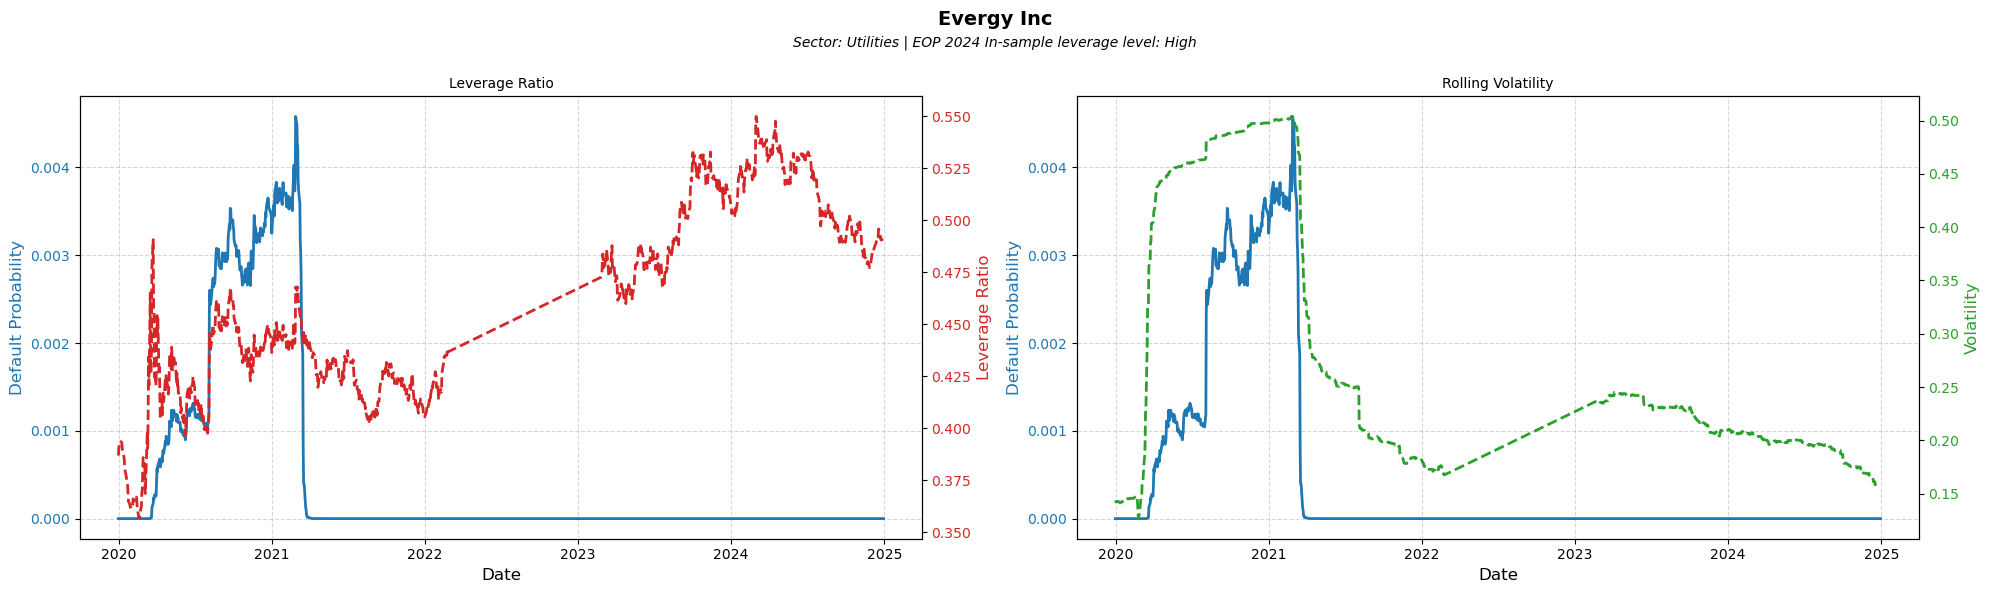

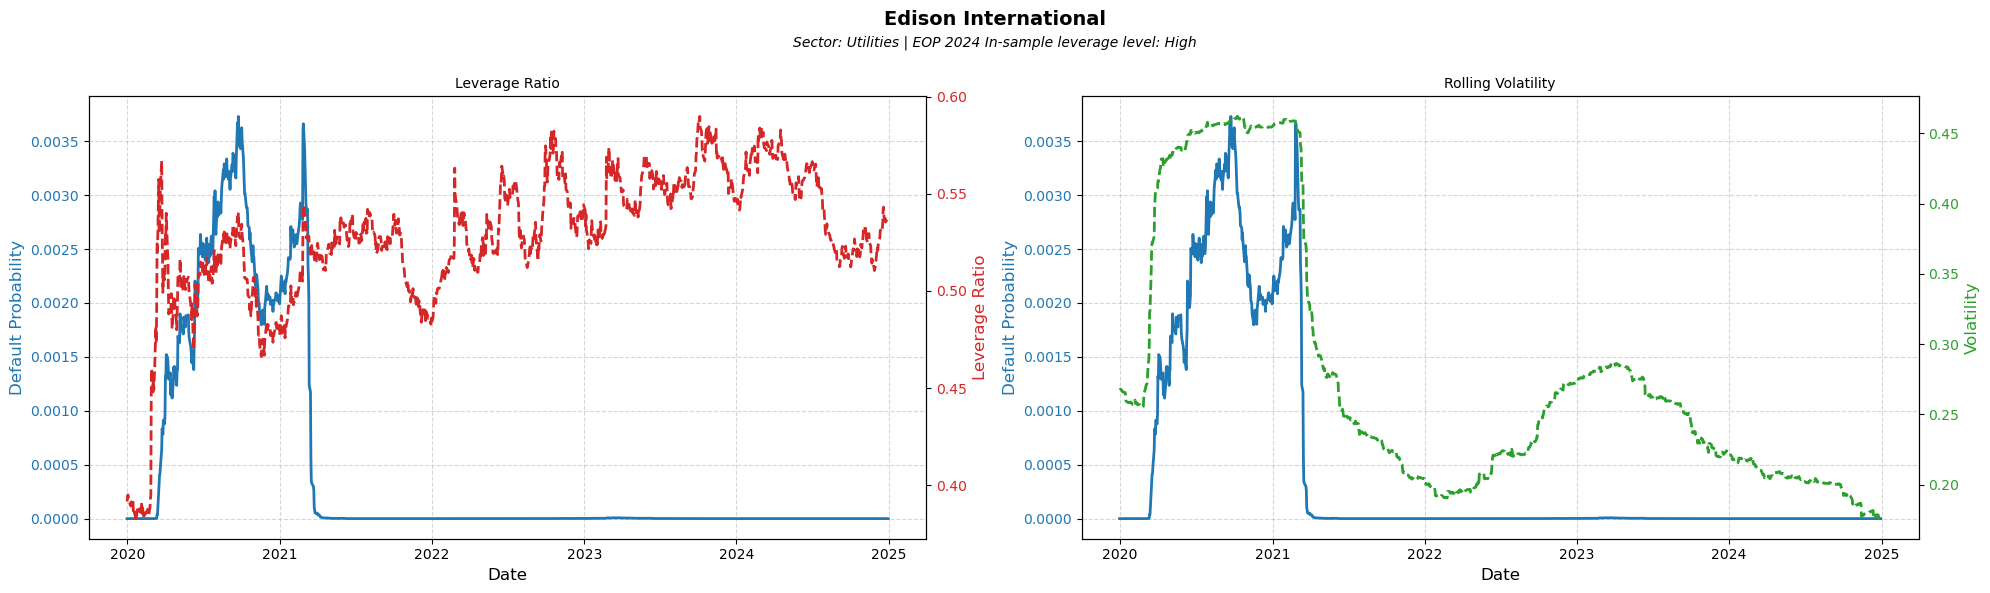

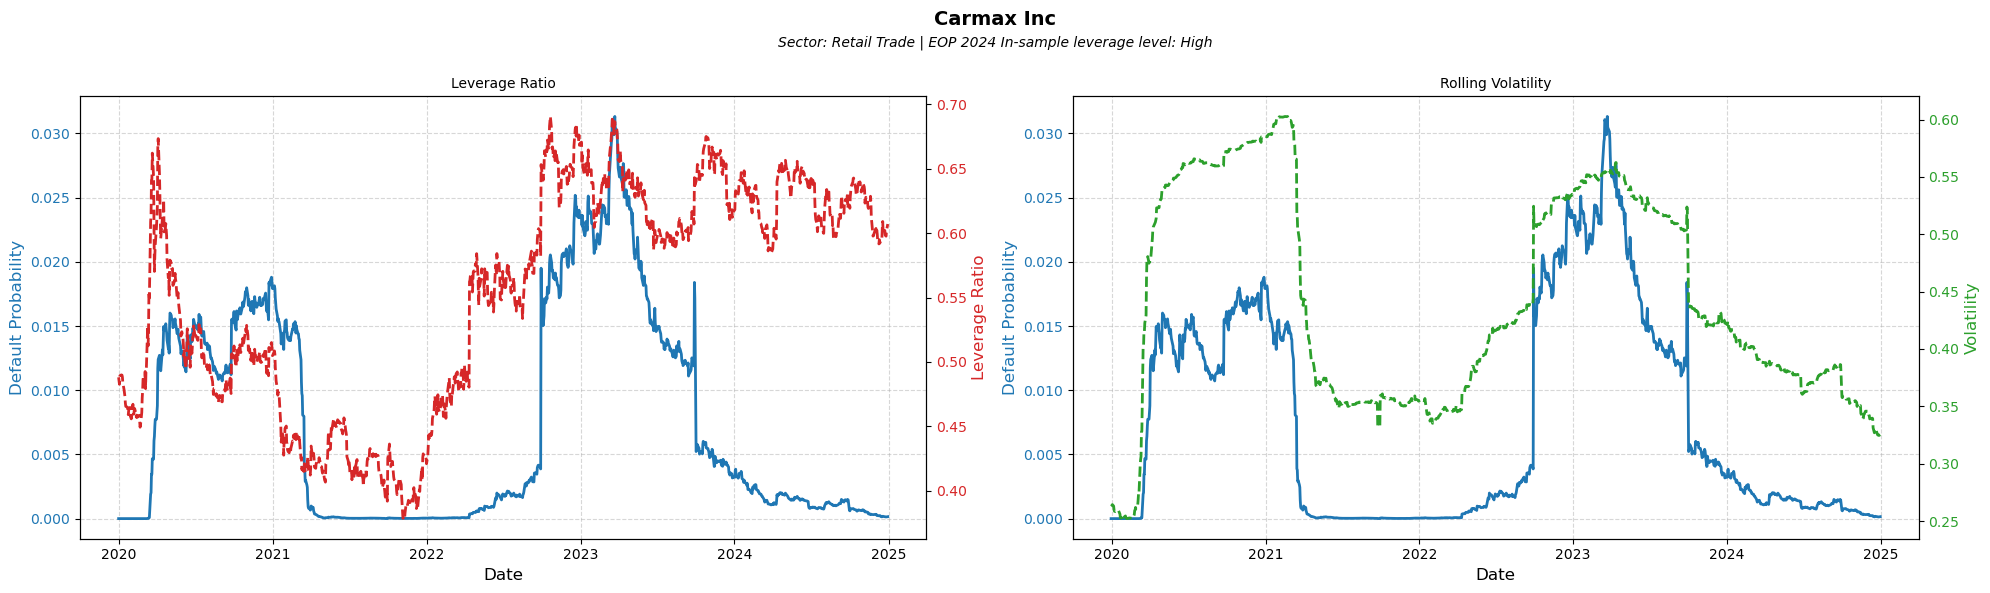

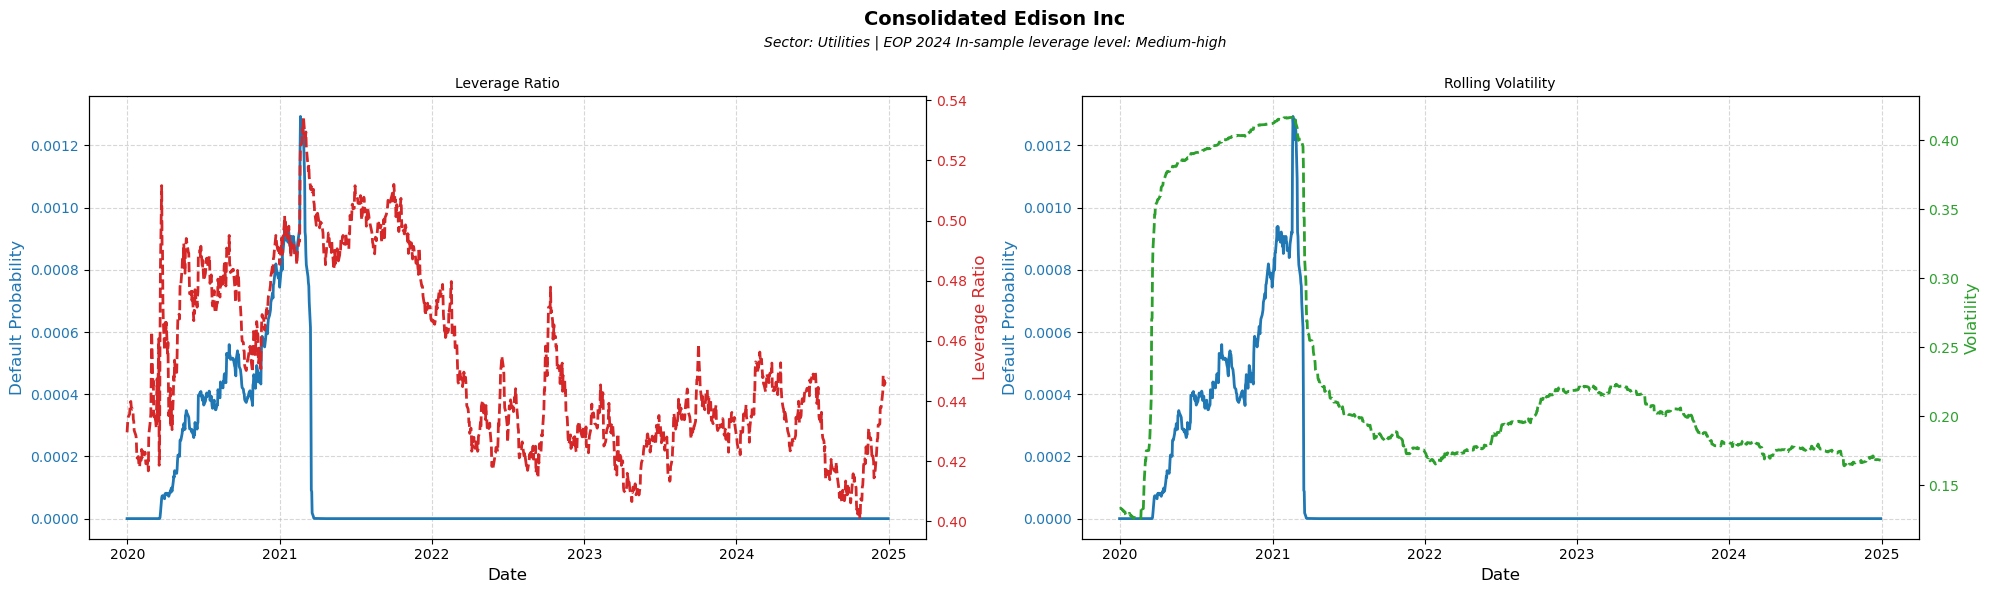

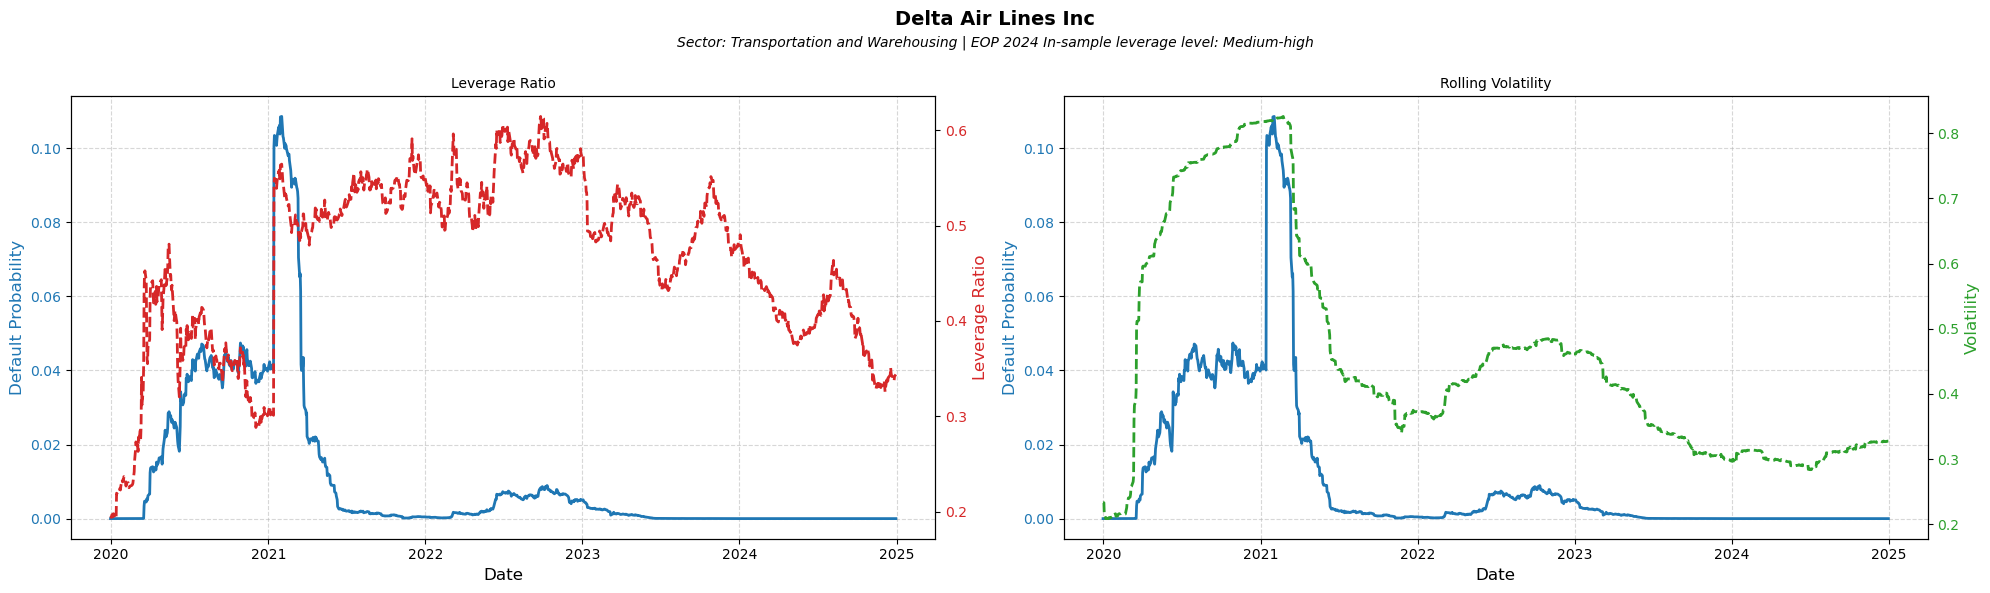

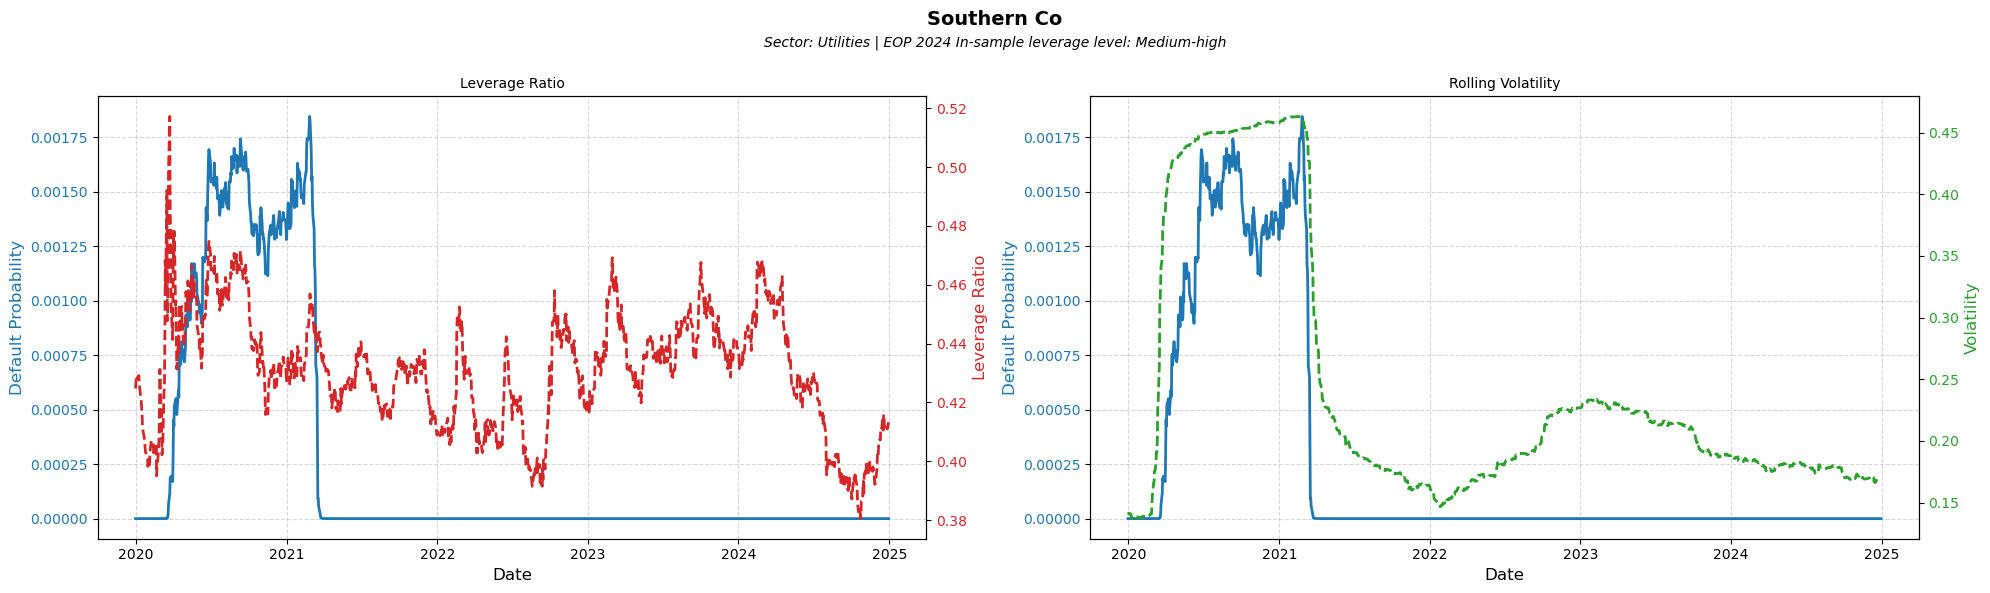

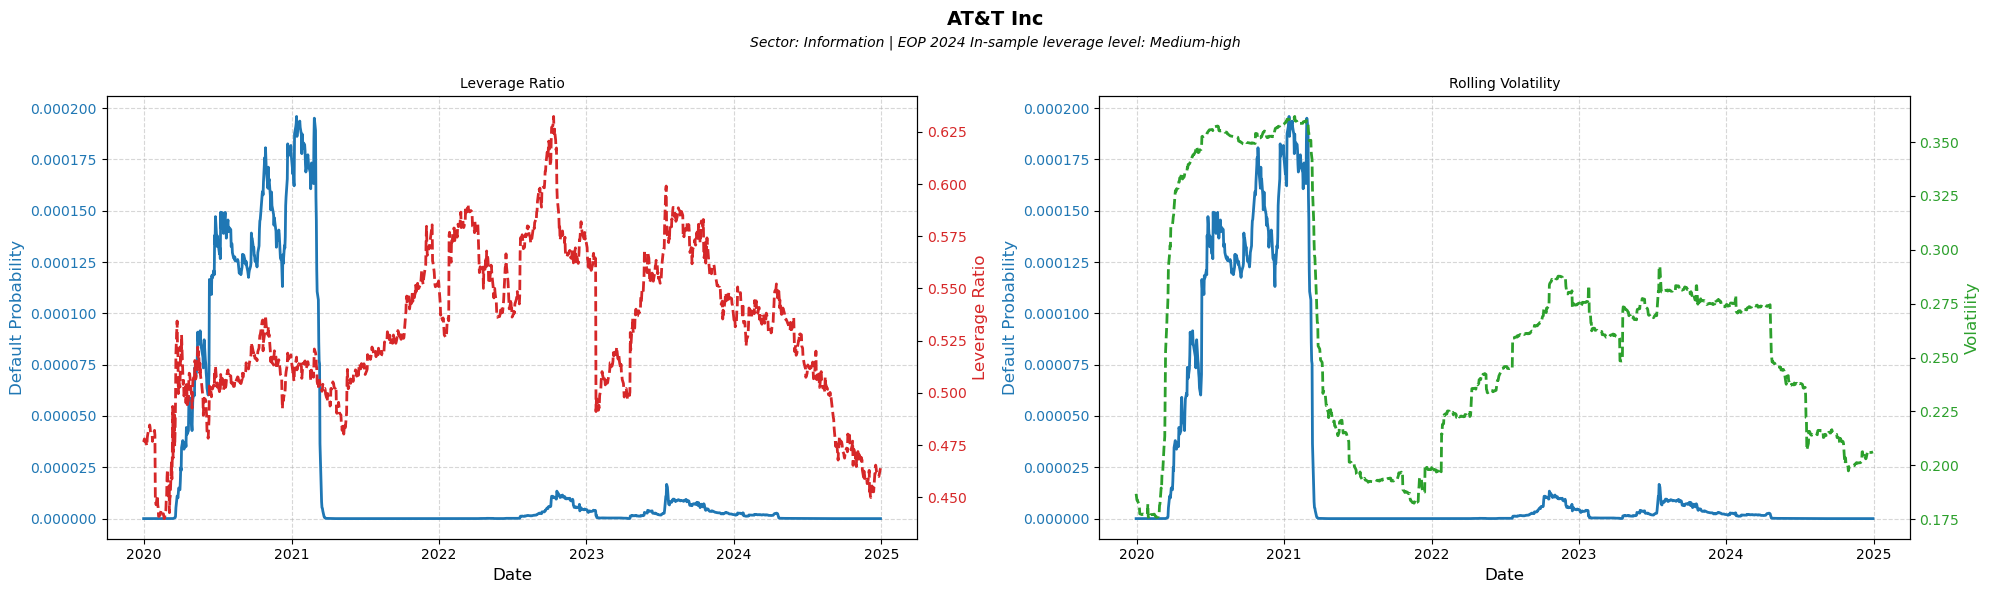

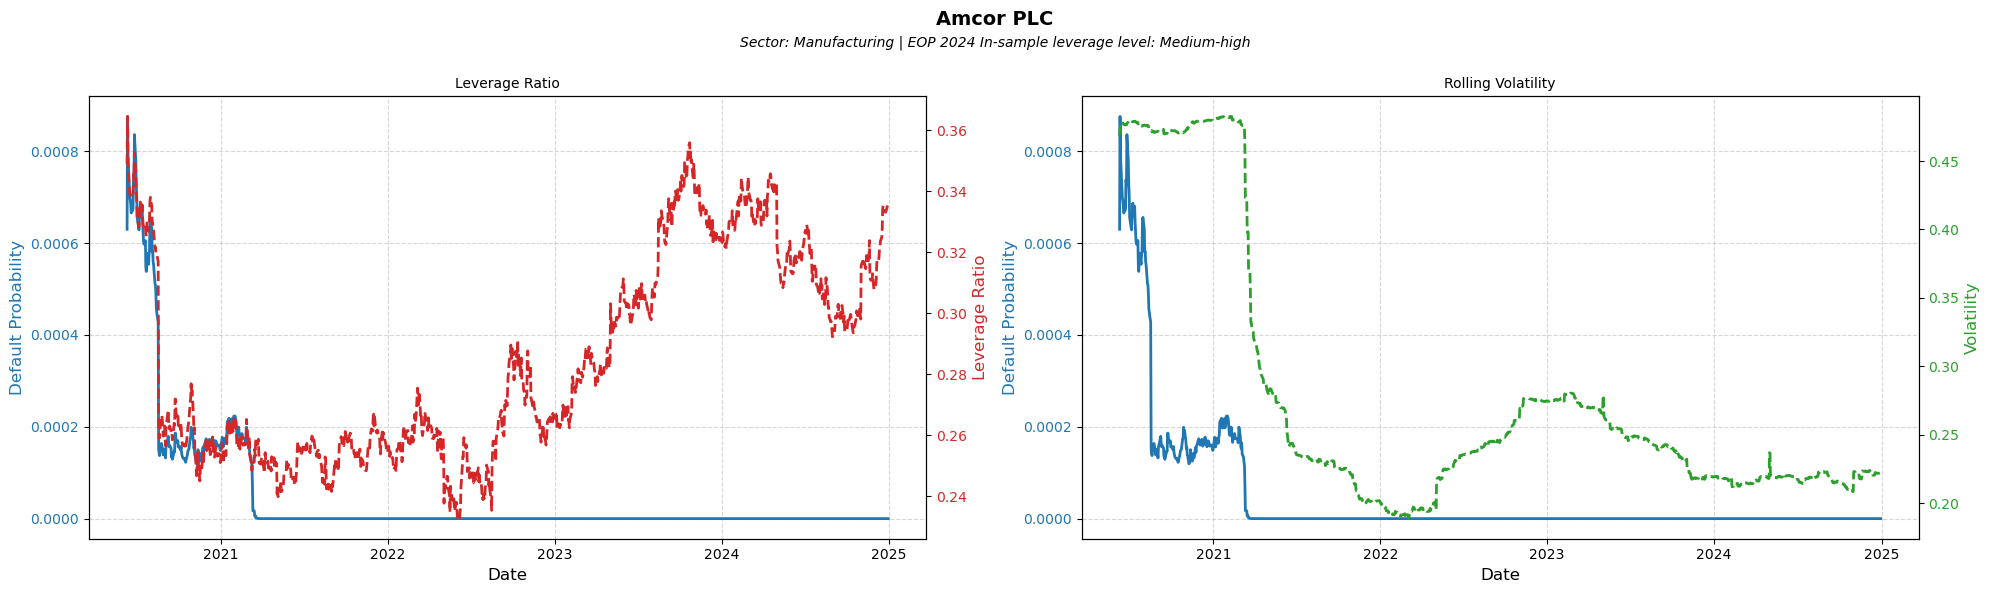

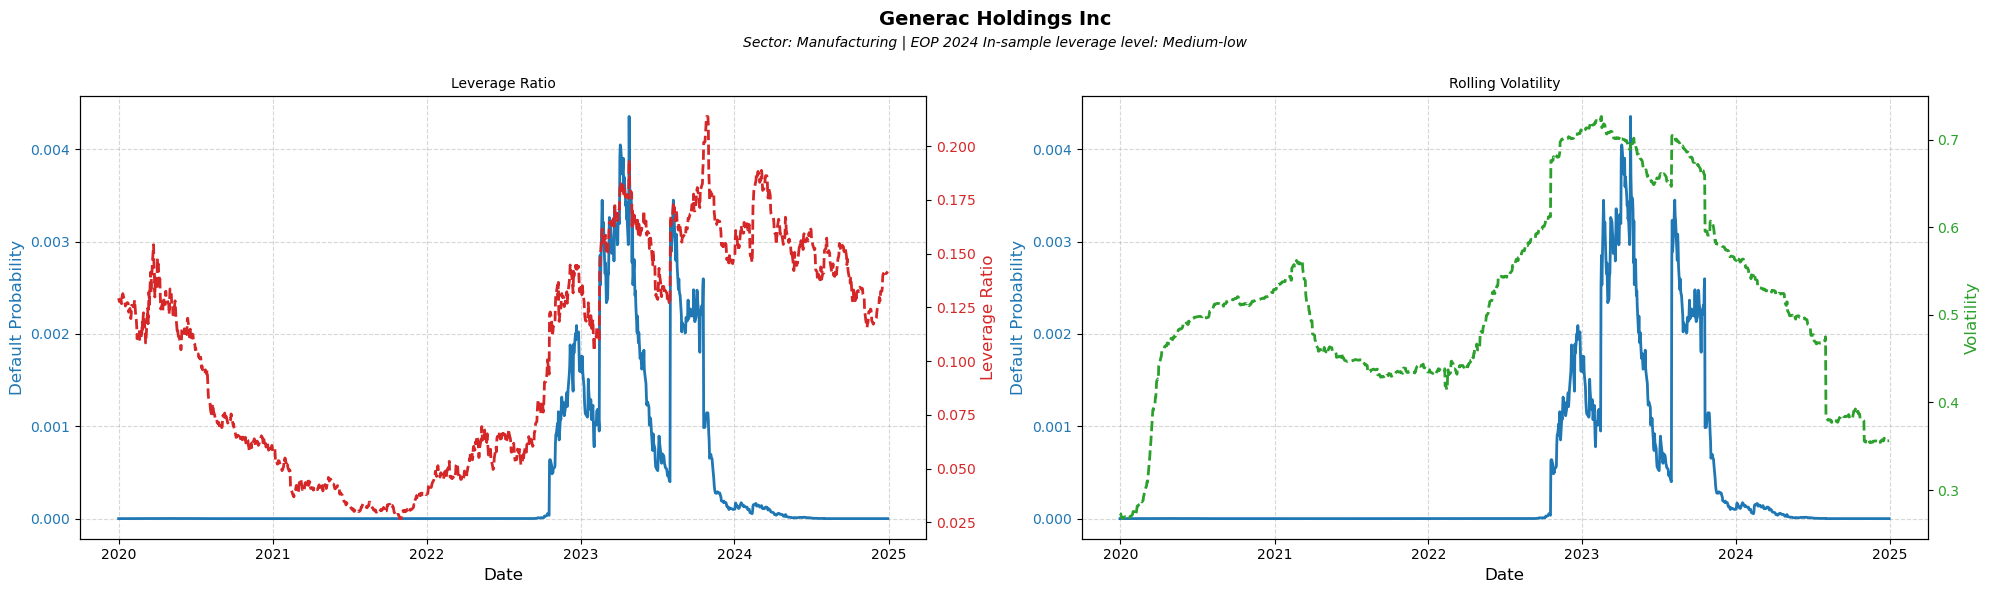

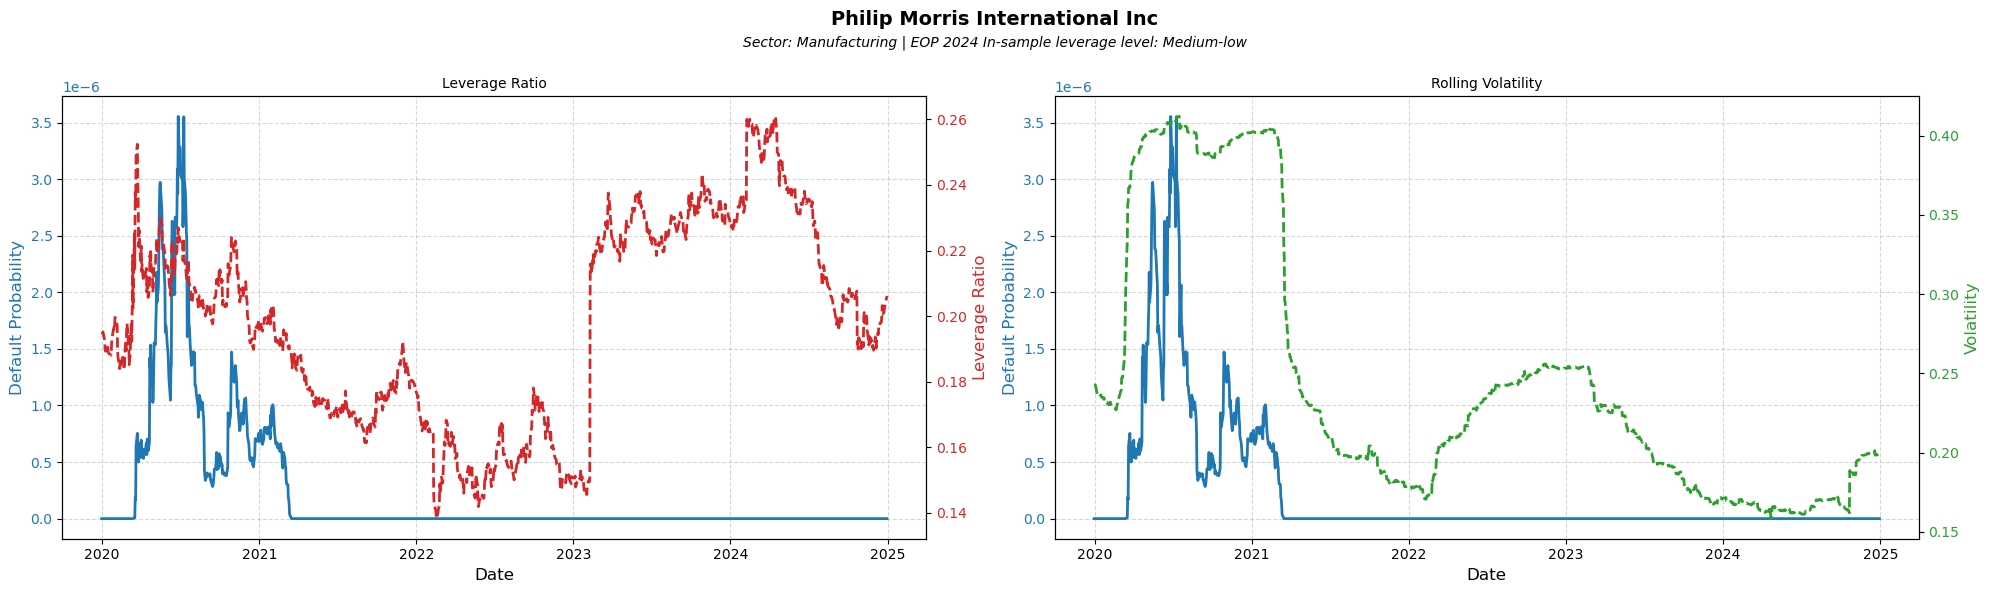

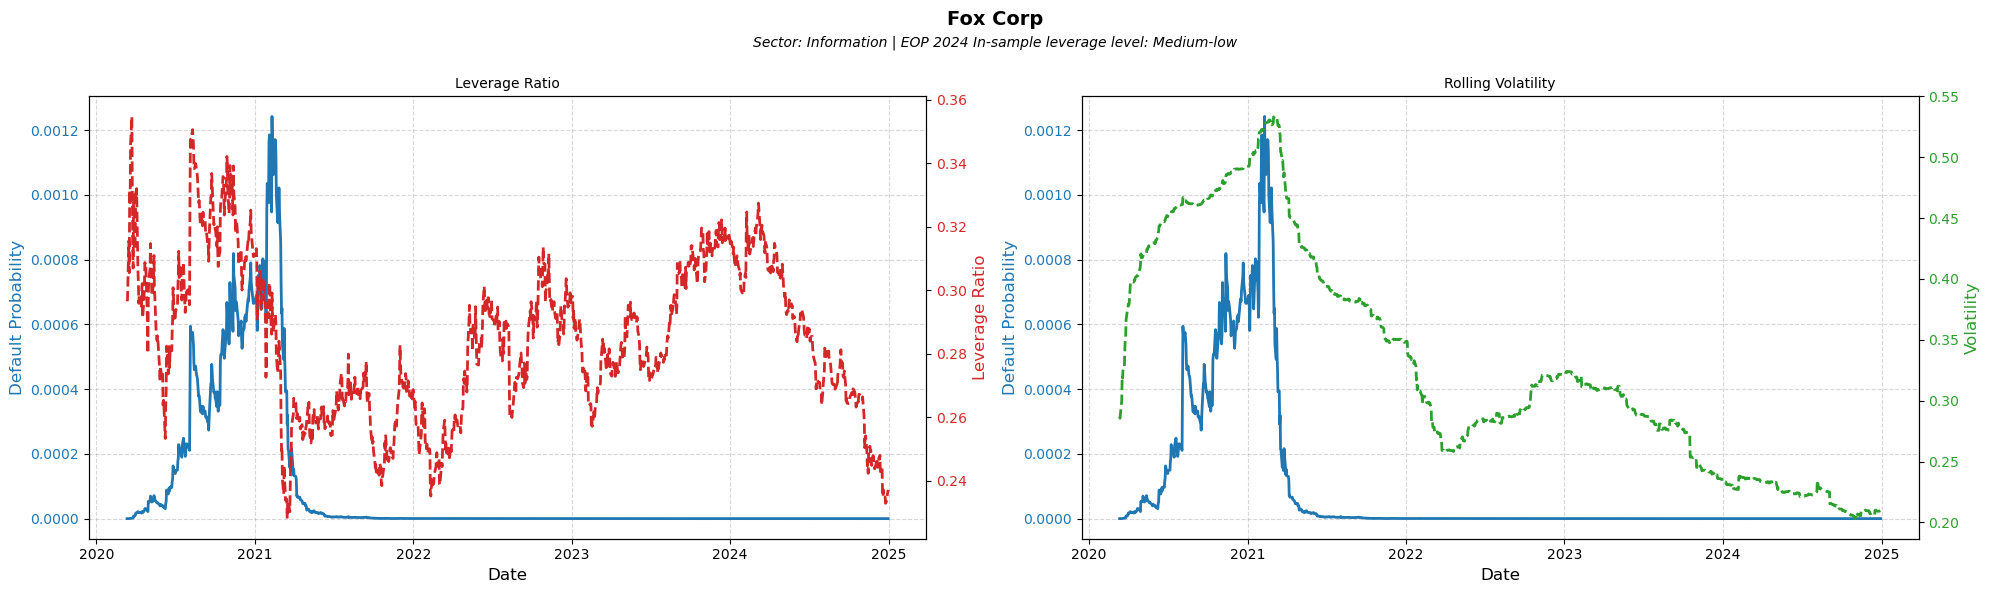

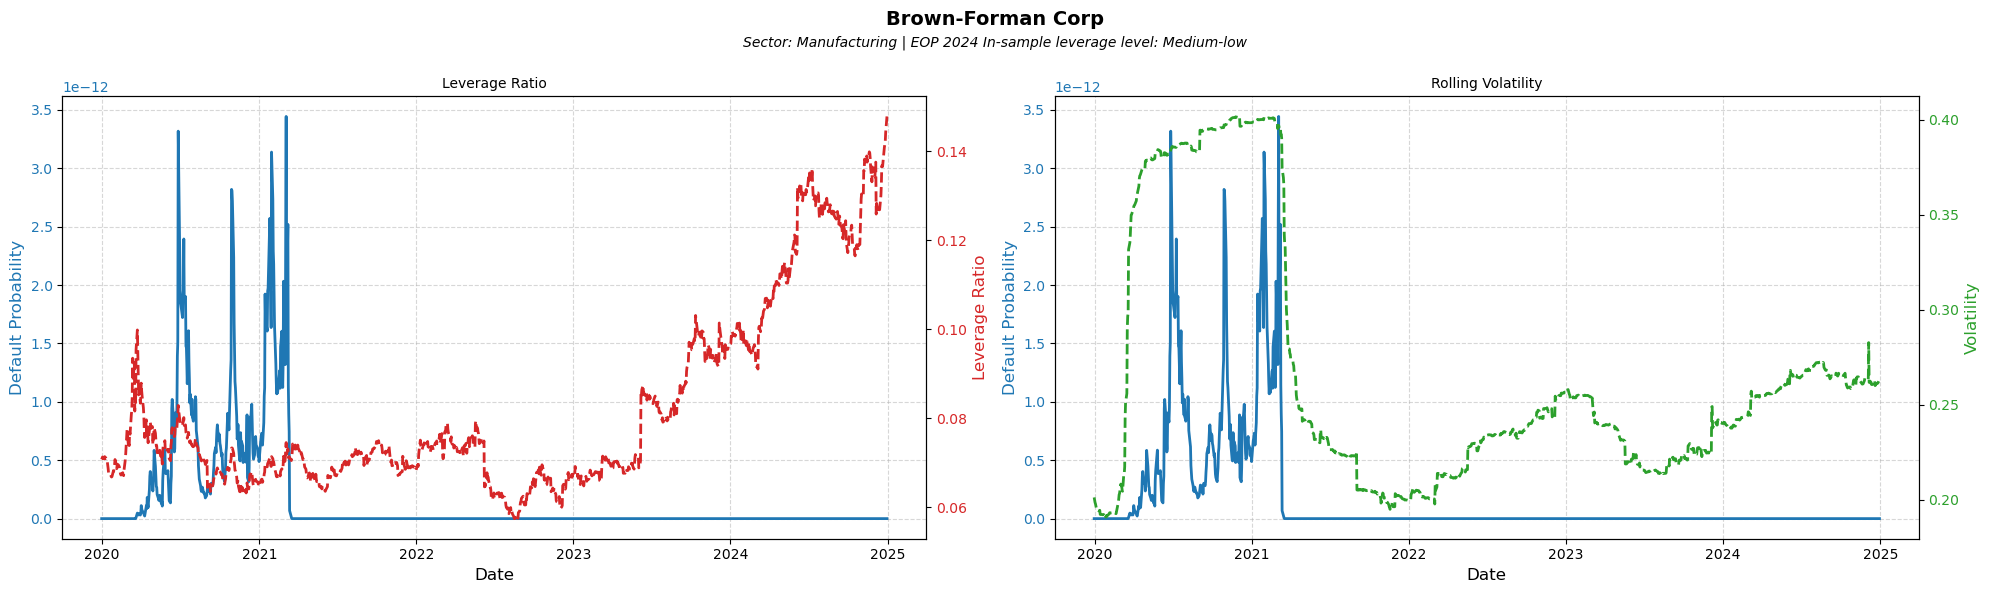

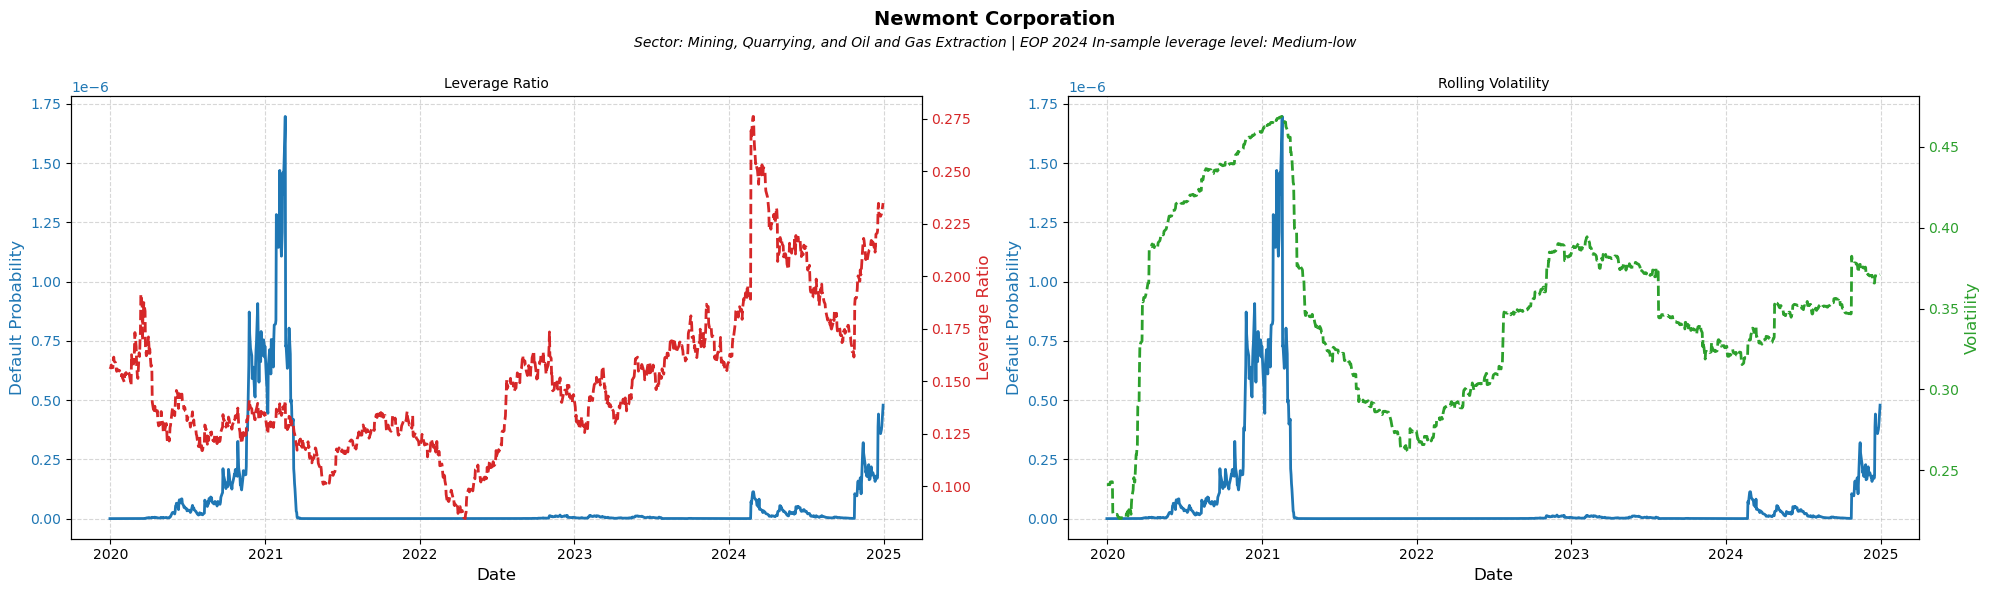

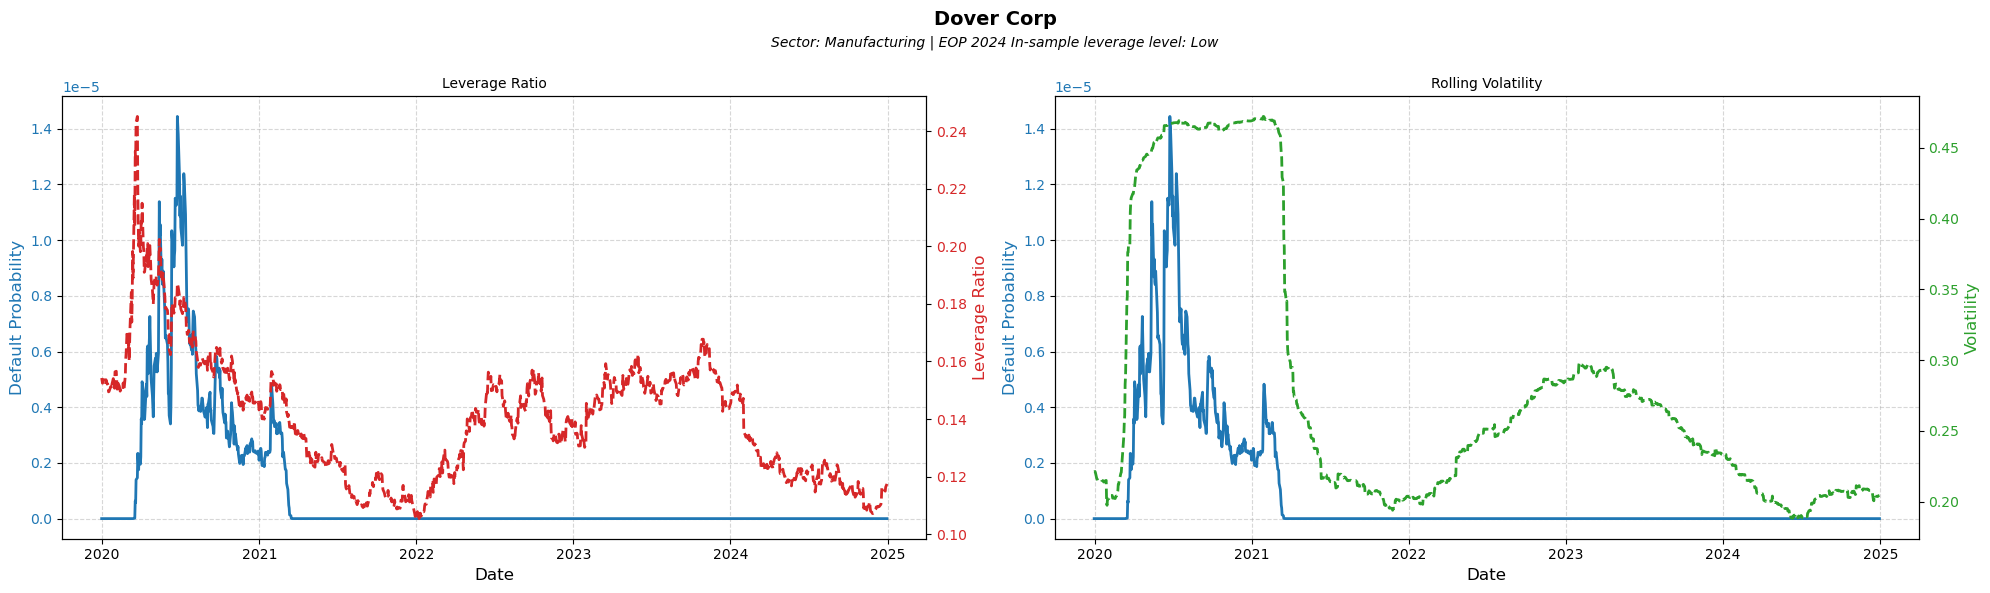

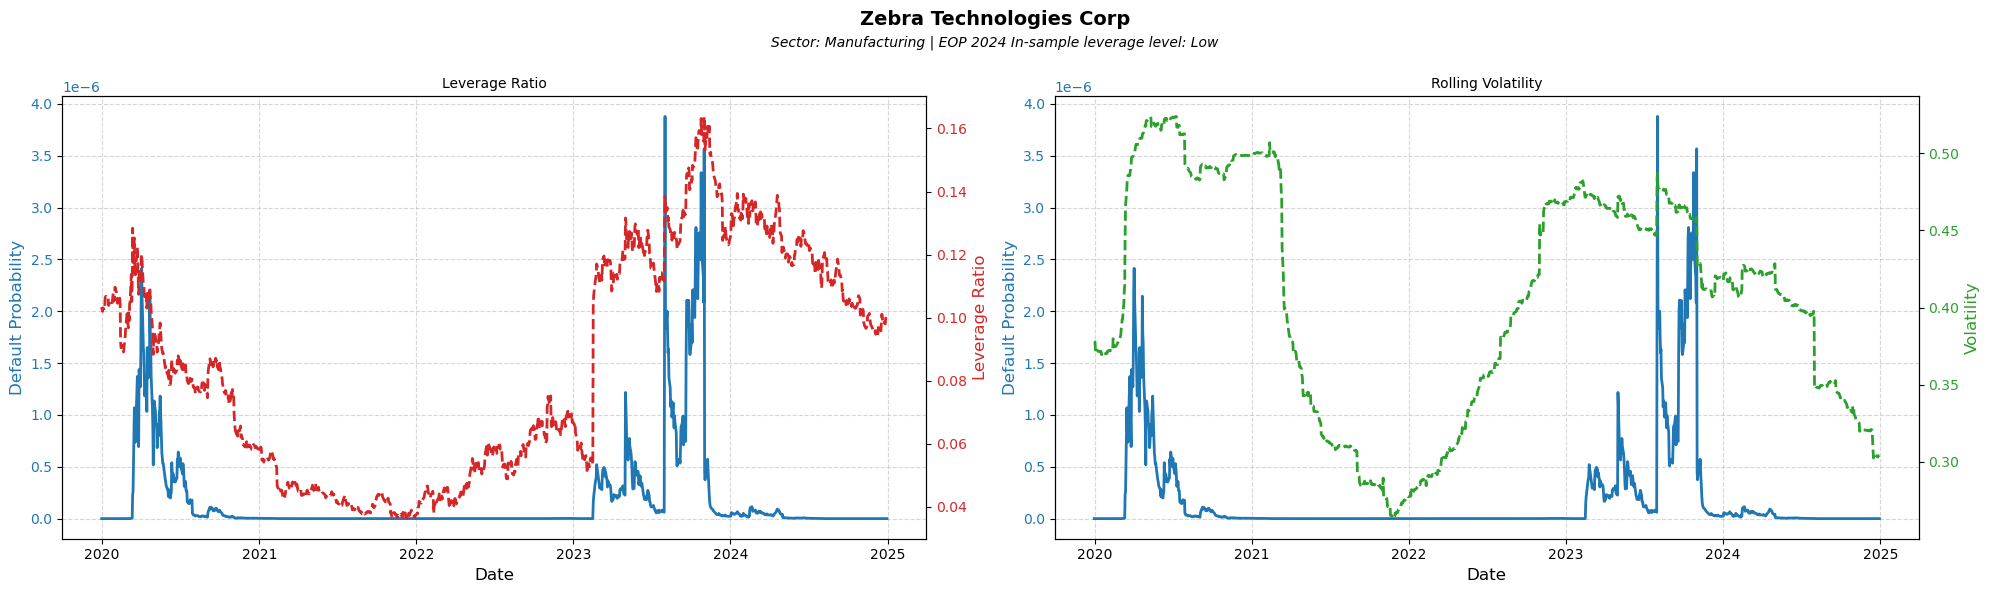

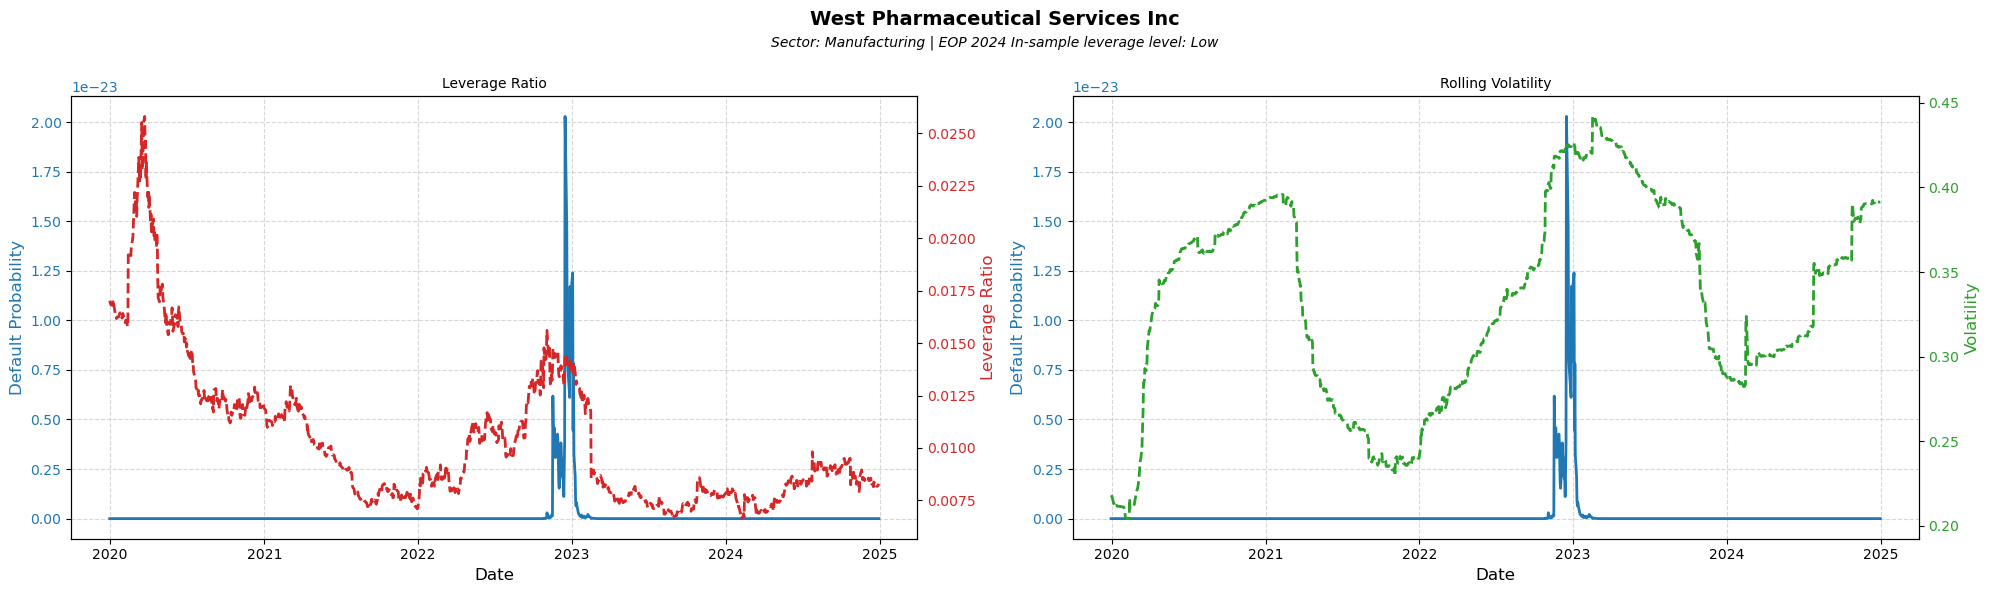

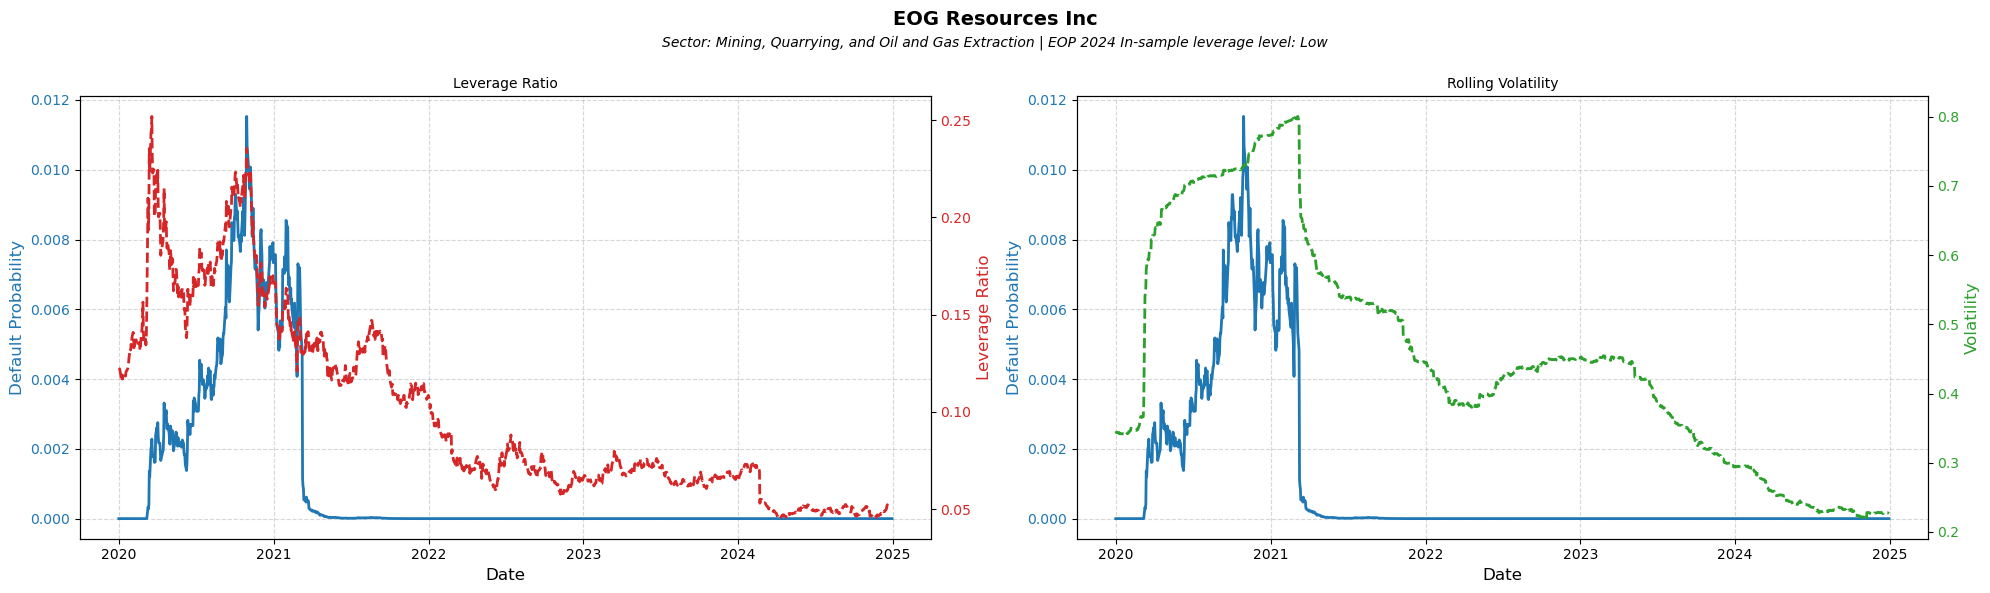

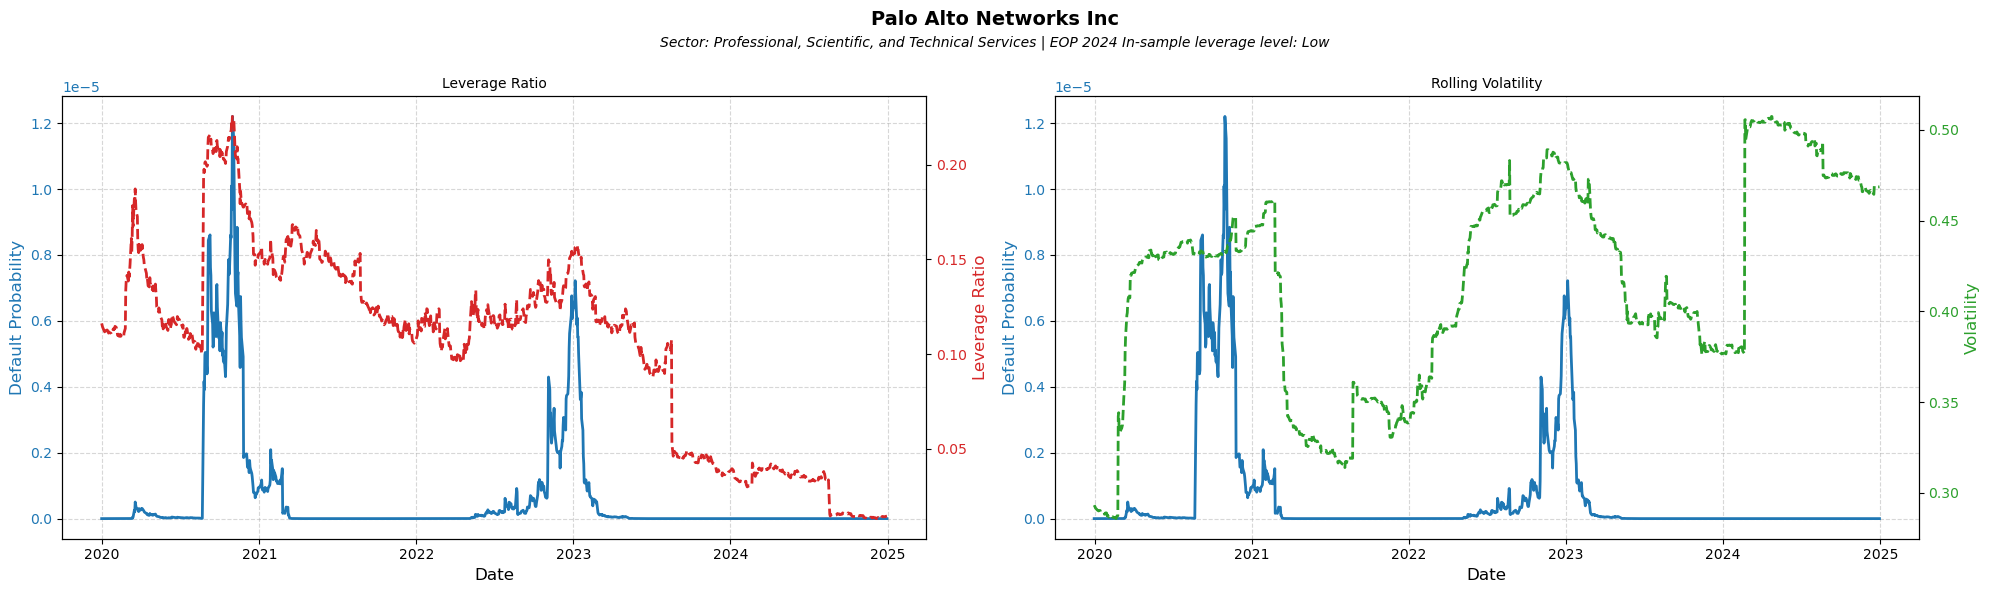

In [97]:
for ric in rics_list:
    row_cross = data_cross[data_cross['Instrument'] == ric]

    sector = row_cross['NAICS Sector Name'].iloc[0]
    cluster = row_cross['ranked_clusters'].iloc[0]

    # Extract data for the first plot
    def_probab_1 = df_final.loc[ric]['Default_Probability']
    leverage_ratio_1 = df_final.loc[ric]['Leverage_Ratio']

    # Extract data for the second plot
    def_probab_2 = df_final.loc[ric]['Default_Probability']
    leverage_ratio_2 = df_final.loc[ric]['Rolling_Volatility']

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=False)

    # First plot (Default Probability vs Leverage Ratio)
    color1 = 'tab:blue'
    ax1.plot(def_probab_1, color=color1, label='Default Probability', linewidth=2)
    ax1.set_ylabel('Default Probability', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis for the first plot
    ax1_twin = ax1.twinx()
    color2 = 'tab:red'
    ax1_twin.plot(leverage_ratio_1, color=color2, label='Leverage Ratio', linewidth=2, linestyle='dashed')
    ax1_twin.set_ylabel('Leverage Ratio', color=color2, fontsize=12)
    ax1_twin.tick_params(axis='y', labelcolor=color2)
    ax1.set_title(f"Leverage Ratio", fontsize=10)

    # Second plot (Default Probability vs Rolling Volatility)
    color3 = 'tab:blue'
    ax2.plot(def_probab_2, color=color3, label='Default Probability', linewidth=2)
    ax2.set_ylabel('Default Probability', color=color3, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color3)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis for the second plot
    ax2_twin = ax2.twinx()
    color4 = 'tab:green'
    ax2_twin.plot(leverage_ratio_2, color=color4, label='Volatility', linewidth=2, linestyle='dashed')
    ax2_twin.set_ylabel('Volatility', color=color4, fontsize=12)
    ax2_twin.tick_params(axis='y', labelcolor=color4)
    ax2.set_title(f"Rolling Volatility", fontsize=10)

    # Adjust layout and overall title
    fig.suptitle(f'{rics_dict[ric]}', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.92, f"Sector: {sector} | EOP 2024 In-sample leverage level: {cluster_dict[cluster]}", 
         fontsize=10, fontstyle='italic', ha='center')
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin for the suptitle

    # Show the combined plot
    plt.show()


### Plotting the **credit spread** through time as a function of the leverage ratio and volatility

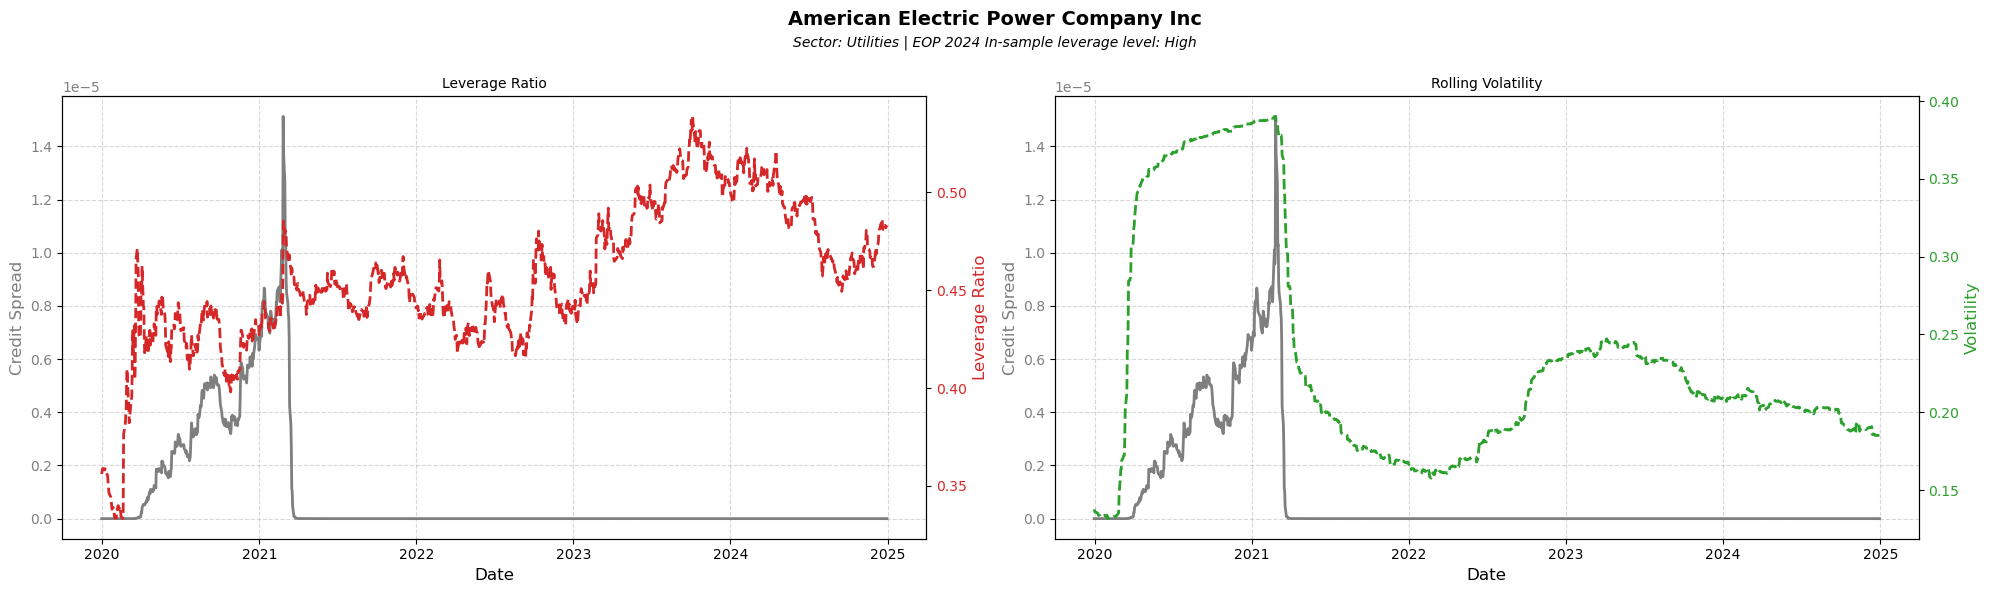

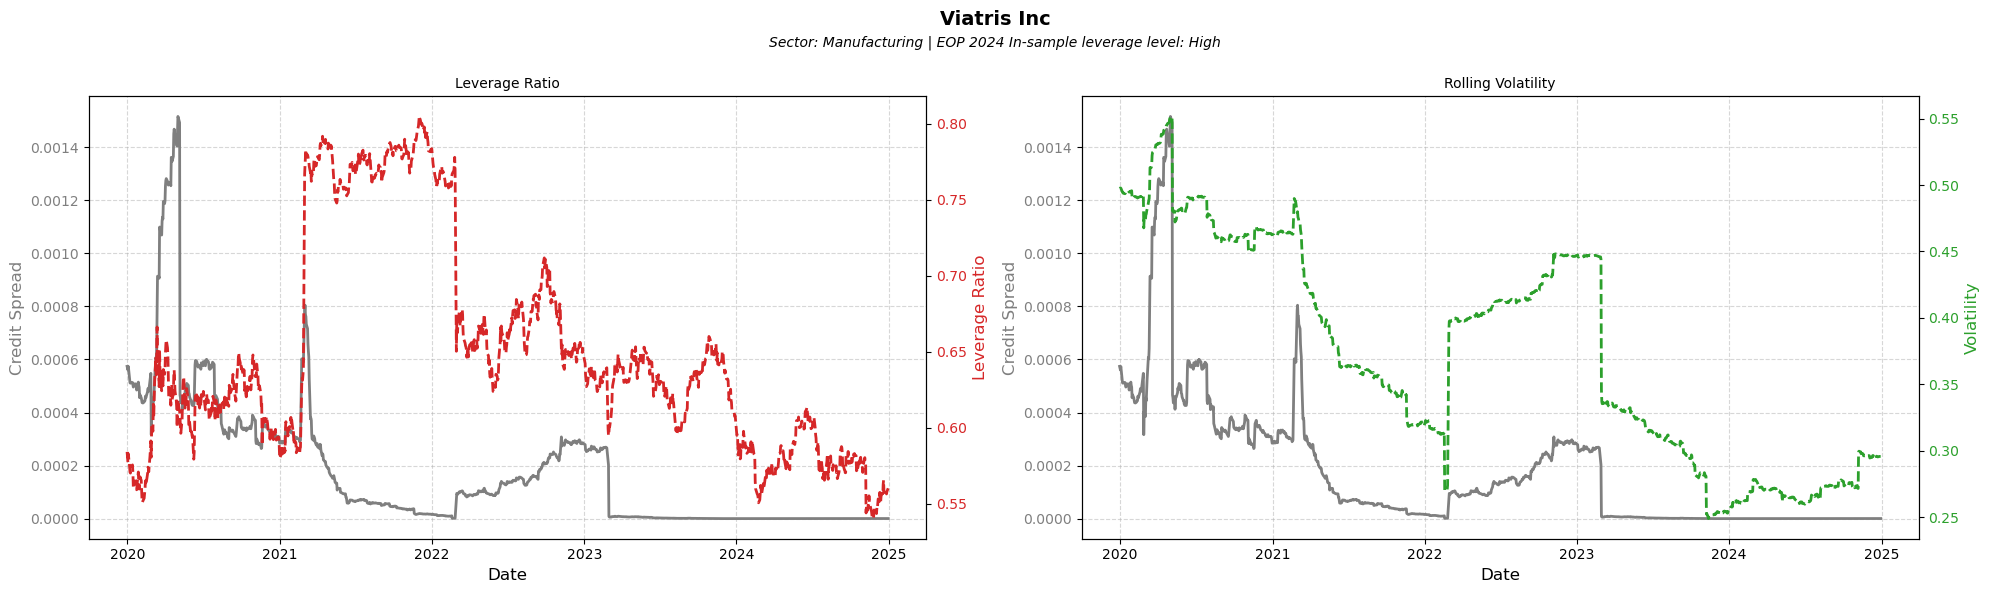

KeyboardInterrupt: 

In [98]:
for ric in rics_list:
    row_cross = data_cross[data_cross['Instrument'] == ric]

    sector = row_cross['NAICS Sector Name'].iloc[0]
    cluster = row_cross['ranked_clusters'].iloc[0]

    # Extract data for the first plot
    def_probab_1 = df_final.loc[ric]['Credit_Spread']
    leverage_ratio_1 = df_final.loc[ric]['Leverage_Ratio']

    # Extract data for the second plot
    def_probab_2 = df_final.loc[ric]['Credit_Spread']
    leverage_ratio_2 = df_final.loc[ric]['Rolling_Volatility']

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=False)

    # First plot (Credit Spreadvs Leverage Ratio)
    color1 = 'tab:grey'
    ax1.plot(def_probab_1, color=color1, label='Credit Spread', linewidth=2)
    ax1.set_ylabel('Credit Spread', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis for the first plot
    ax1_twin = ax1.twinx()
    color2 = 'tab:red'
    ax1_twin.plot(leverage_ratio_1, color=color2, label='Leverage Ratio', linewidth=2, linestyle='dashed')
    ax1_twin.set_ylabel('Leverage Ratio', color=color2, fontsize=12)
    ax1_twin.tick_params(axis='y', labelcolor=color2)
    ax1.set_title(f"Leverage Ratio", fontsize=10)

    # Second plot (Credit Spreadvs Rolling Volatility)
    color3 = 'tab:grey'
    ax2.plot(def_probab_2, color=color3, label='Credit Spread', linewidth=2)
    ax2.set_ylabel('Credit Spread', color=color3, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color3)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis for the second plot
    ax2_twin = ax2.twinx()
    color4 = 'tab:green'
    ax2_twin.plot(leverage_ratio_2, color=color4, label='Volatility', linewidth=2, linestyle='dashed')
    ax2_twin.set_ylabel('Volatility', color=color4, fontsize=12)
    ax2_twin.tick_params(axis='y', labelcolor=color4)
    ax2.set_title(f"Rolling Volatility", fontsize=10)

    # Adjust layout and overall title
    fig.suptitle(f'{rics_dict[ric]}', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.92, f"Sector: {sector} | EOP 2024 In-sample leverage level: {cluster_dict[cluster]}", 
         fontsize=10, fontstyle='italic', ha='center')
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin for the suptitle

    # Show the combined plot
    plt.show()


#### Debugging the credit spread

In [99]:
r = 0.01
T = 1
t = 0

sigma = 0.25


V = 3837473534.932722
#K = 931124000.0 * 2


p_0 = np.exp(-r * (T - t))
K = (V * 0.6) / p_0

# 2) Calculate d1 and d2
d1 = (-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t)) / (sigma * np.sqrt(T -t))

d2 = d1 - (sigma * np.sqrt(T - t))

# 3) *Defaultable* bond price using Merton's debt formula
#defaultable_bond = K * riskless * norm.cdf(d2) + V * (1 - norm.cdf(d1))

# 4) Credit spread calculation: -1/(T - t) * ln(defaultable_bond / riskless_bond)
credit_spread = -1/(T - t) * np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))

print(f'Debt-to-value: {K/V}')
print(f'Log: {-(np.log((K*p_0)/V))}')
print(f'Numerator: {(-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t))}')
print(f'Volatility: {sigma}')
print(f'd1: {d1}')
print(f'First addend: {np.log(norm.cdf(d2) )}' )
print(f'Second addend: {(V/(K *p_0))*norm.cdf(-d1)}')
print(f'Not discounted: {-np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))}')
print(f'Credit spread: {credit_spread}')

Debt-to-value: 0.6060301002505009
Log: 0.5108256237659907
Numerator: 0.5420756237659907
Volatility: 0.25
d1: 2.168302495063963
First addend: -0.027922564726853342
Second addend: 0.025113065607051538
Not discounted: 0.00242620838220305
Credit spread: 0.00242620838220305


In [100]:
#Test the credit spread model with mock examples
af.credit_spread_model(V = 40, K = 15, sigma = 0.4, r = 0.04, T = 5, t = 0)

0.013587038390588863

### Theoretical Impact of Volatility on Credit Spread

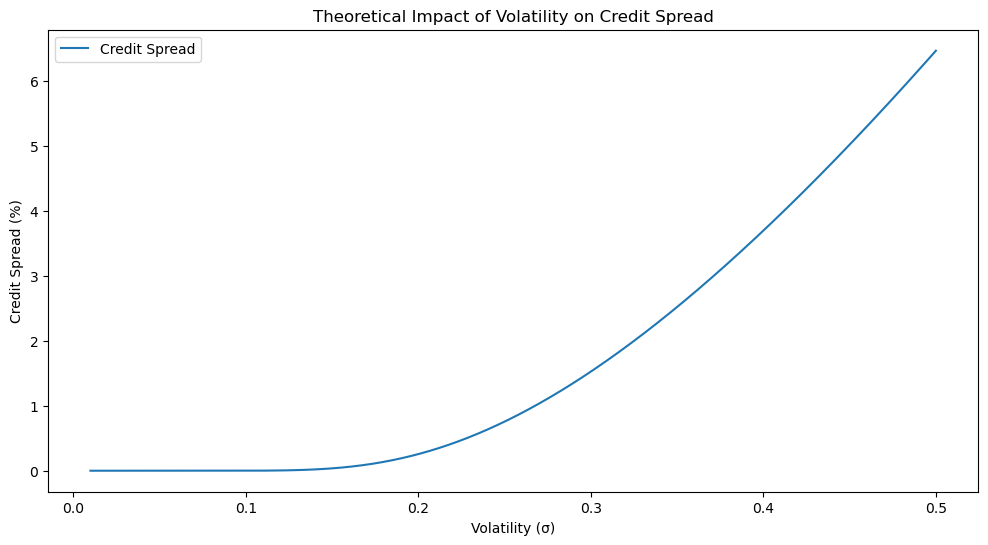

In [101]:
mp.plot_spread_vol(100,60,0,2,0)

### Theoretical Impact of Time on Credit Spread

We create a dataframe with the last observed day for each stock with all the computed quantities from before.

In [102]:
last_obs_df = pd.DataFrame(columns = df_final.columns, index = rics_list)
for ric in rics_list:

    row = df_final.loc[ric].iloc[-1]
    last_obs_df.loc[ric, :] = row

print(last_obs_df)

last_obs_df = last_obs_df.sort_values(by = 'Default_Probability', ascending = False)


        Close Price Shares used to calculate Diluted EPS - Total  \
AEP.OQ        92.06                                  520206258.0   
VTRS.OQ       12.38                                 1206900000.0   
EVRG.OQ       61.52                                  230500000.0   
EIX.N         79.68                                  385000000.0   
KMX.N         82.06                                  158707000.0   
ED.N          89.16                                  349300000.0   
DAL.N         60.72                                  643000000.0   
SO.N          82.38                                 1098000000.0   
T.N           22.61                                 7258000000.0   
AMCR.N         9.34                                 1441000000.0   
GNRC.N       154.74                                   62058387.0   
PM.N         120.01                                 1553000000.0   
FOXA.OQ       48.84                                  480000000.0   
BFb.N         37.72                             

In [103]:
last_obs_df

Close Price Shares used to calculate Diluted EPS - Total  \
KMX.N         82.06                                  158707000.0   
VTRS.OQ       12.38                                 1206900000.0   
DAL.N         60.72                                  643000000.0   
NEM.N          37.0                                  841000000.0   
GNRC.N       154.74                                   62058387.0   
T.N           22.61                                 7258000000.0   
AMCR.N         9.34                                 1441000000.0   
EIX.N         79.68                                  385000000.0   
AEP.OQ        92.06                                  520206258.0   
ZBRA.OQ      383.85                                   51710962.0   
ED.N          89.16                                  349300000.0   
BFb.N         37.72                                  477220000.0   
EVRG.OQ       61.52                                  230500000.0   
SO.N          82.38                                 1098000000.0   
FOXA.OQ       48.84                                  480000000.0   
PANW.OQ       184.2                                  354000000.0   
PM.N         120.01                                 1553000000.0   
DOV.N        186.32                                  140599000.0   
WST.N        328.82                                   75300000.0   
EOG.N        120.58                                  584000000.0   

        Market Capitalization    Debt - Total      RIC        Equity_Value  \
KMX.N           12451343181.0   18976741000.0    KMX.N       13023496420.0   
VTRS.OQ        12990936920.85   18131500000.0  VTRS.OQ       14941422000.0   
DAL.N          25886533909.59   20054000000.0    DAL.N       39042960000.0   
NEM.N          32896779988.27    9436000000.0    NEM.N       31117000000.0   
GNRC.N          8044230651.48    1575217000.0   GNRC.N   9602914804.380001   
T.N            119977000000.0  137331000000.0      T.N      164103380000.0   
AMCR.N     14135456613.360001    6699000000.0   AMCR.N       13458940000.0   
EIX.N      27421327292.369999   34090000000.0    EIX.N  30676800000.000004   
AEP.OQ     42711651075.379997   43179000000.0   AEP.OQ  47890188111.480003   
ZBRA.OQ    14032315032.120001    2220000000.0  ZBRA.OQ  19849252763.700001   
ED.N       31377698527.450001   24467000000.0     ED.N       31143588000.0   
BFb.N      22820225310.119999    3100000000.0    BFb.N       18000738400.0   
EVRG.OQ    11990452438.799999   13201800000.0  EVRG.OQ       14180360000.0   
SO.N       76469126119.479996   62000000000.0     SO.N       90453240000.0   
FOXA.OQ        15487934457.34    7197000000.0  FOXA.OQ       23443200000.0   
PANW.OQ        105147574000.0     963900000.0  PANW.OQ  65206799999.999992   
PM.N      146050355633.279999   47909000000.0     PM.N      186375530000.0   
DOV.N      21516503048.639999    3469008000.0    DOV.N       26196405680.0   
WST.N      26053242600.400002     206800000.0    WST.N       24760146000.0   
EOG.N      70424455613.100006    3799000000.0    EOG.N       70418720000.0   

        Log_Returns Rolling_Volatility         Total_value  \
KMX.N     -0.020624            0.32529       32000237420.0   
VTRS.OQ   -0.008045           0.295775       33072922000.0   
DAL.N     -0.008854           0.327727       59096960000.0   
NEM.N     -0.022449           0.370962       40553000000.0   
GNRC.N    -0.005992           0.356244  11178131804.380001   
T.N       -0.010996           0.206243      301434380000.0   
AMCR.N     -0.01065           0.222089       20157940000.0   
EIX.N      -0.00138           0.175841       64766800000.0   
AEP.OQ    -0.004876           0.185153  91069188111.480011   
ZBRA.OQ   -0.013507           0.304162  22069252763.700001   
ED.N      -0.004476           0.168118       55610588000.0   
BFb.N     -0.028745           0.263118       21100738400.0   
EVRG.OQ   -0.002922           0.158659       27382160000.0   
SO.N      -0.009183           0.167043      152453240000.0   
FOXA.OQ   

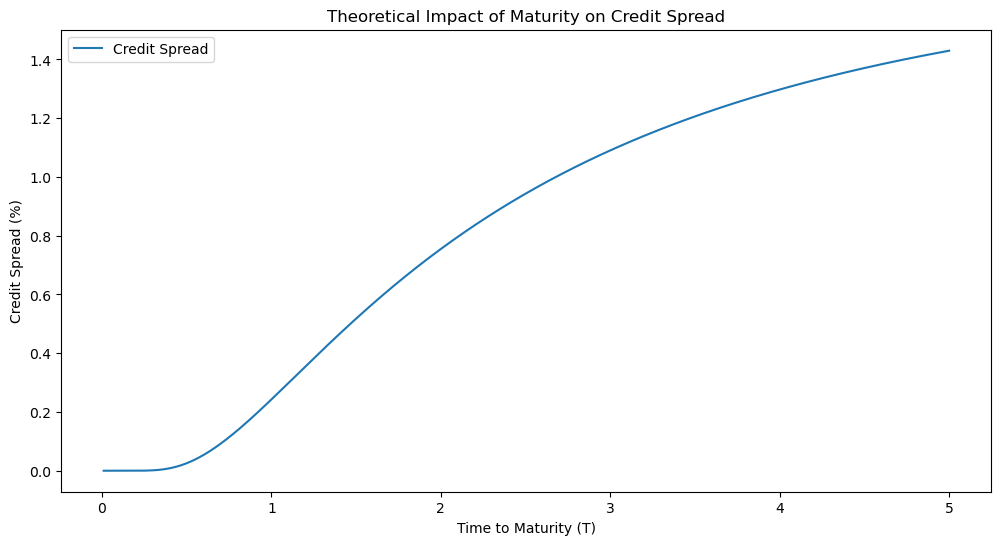

In [ ]:
#Theoretical
mp.plot_spread_time(100,60,0,2,0)

## 4) Monte Carlo simulations of the probability of default 

Due to the fact that we are dealing with rare events which imply the need to have a large number of simulations we have chosen to compute the Monte Carlo approximation of the real-world probability of default just for the last day of observations. 

In [104]:
last_obs_df

Close Price Shares used to calculate Diluted EPS - Total  \
KMX.N         82.06                                  158707000.0   
VTRS.OQ       12.38                                 1206900000.0   
DAL.N         60.72                                  643000000.0   
NEM.N          37.0                                  841000000.0   
GNRC.N       154.74                                   62058387.0   
T.N           22.61                                 7258000000.0   
AMCR.N         9.34                                 1441000000.0   
EIX.N         79.68                                  385000000.0   
AEP.OQ        92.06                                  520206258.0   
ZBRA.OQ      383.85                                   51710962.0   
ED.N          89.16                                  349300000.0   
BFb.N         37.72                                  477220000.0   
EVRG.OQ       61.52                                  230500000.0   
SO.N          82.38                                 1098000000.0   
FOXA.OQ       48.84                                  480000000.0   
PANW.OQ       184.2                                  354000000.0   
PM.N         120.01                                 1553000000.0   
DOV.N        186.32                                  140599000.0   
WST.N        328.82                                   75300000.0   
EOG.N        120.58                                  584000000.0   

        Market Capitalization    Debt - Total      RIC        Equity_Value  \
KMX.N           12451343181.0   18976741000.0    KMX.N       13023496420.0   
VTRS.OQ        12990936920.85   18131500000.0  VTRS.OQ       14941422000.0   
DAL.N          25886533909.59   20054000000.0    DAL.N       39042960000.0   
NEM.N          32896779988.27    9436000000.0    NEM.N       31117000000.0   
GNRC.N          8044230651.48    1575217000.0   GNRC.N   9602914804.380001   
T.N            119977000000.0  137331000000.0      T.N      164103380000.0   
AMCR.N     14135456613.360001    6699000000.0   AMCR.N       13458940000.0   
EIX.N      27421327292.369999   34090000000.0    EIX.N  30676800000.000004   
AEP.OQ     42711651075.379997   43179000000.0   AEP.OQ  47890188111.480003   
ZBRA.OQ    14032315032.120001    2220000000.0  ZBRA.OQ  19849252763.700001   
ED.N       31377698527.450001   24467000000.0     ED.N       31143588000.0   
BFb.N      22820225310.119999    3100000000.0    BFb.N       18000738400.0   
EVRG.OQ    11990452438.799999   13201800000.0  EVRG.OQ       14180360000.0   
SO.N       76469126119.479996   62000000000.0     SO.N       90453240000.0   
FOXA.OQ        15487934457.34    7197000000.0  FOXA.OQ       23443200000.0   
PANW.OQ        105147574000.0     963900000.0  PANW.OQ  65206799999.999992   
PM.N      146050355633.279999   47909000000.0     PM.N      186375530000.0   
DOV.N      21516503048.639999    3469008000.0    DOV.N       26196405680.0   
WST.N      26053242600.400002     206800000.0    WST.N       24760146000.0   
EOG.N      70424455613.100006    3799000000.0    EOG.N       70418720000.0   

        Log_Returns Rolling_Volatility         Total_value  \
KMX.N     -0.020624            0.32529       32000237420.0   
VTRS.OQ   -0.008045           0.295775       33072922000.0   
DAL.N     -0.008854           0.327727       59096960000.0   
NEM.N     -0.022449           0.370962       40553000000.0   
GNRC.N    -0.005992           0.356244  11178131804.380001   
T.N       -0.010996           0.206243      301434380000.0   
AMCR.N     -0.01065           0.222089       20157940000.0   
EIX.N      -0.00138           0.175841       64766800000.0   
AEP.OQ    -0.004876           0.185153  91069188111.480011   
ZBRA.OQ   -0.013507           0.304162  22069252763.700001   
ED.N      -0.004476           0.168118       55610588000.0   
BFb.N     -0.028745           0.263118       21100738400.0   
EVRG.OQ   -0.002922           0.158659       27382160000.0   
SO.N      -0.009183           0.167043      152453240000.0   
FOXA.OQ   

In [105]:
importlib.reload(af)
importlib.reload(mp)
import time as time
mc_probabilities = []
approx_error = {}

for ric in rics_list:

    row = last_obs_df.loc[ric,:]
    
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    r = 0.04
    #r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time
    M = 1_000_000

    print('-'*100)
    print(f'{rics_dict[ric]}\n')
    print(row)
    print('\n')
    
    merton_prob = af.default_probability(V, K, r, sigma, T , t)
    
    
    print(f'\nThe probability of default according to the Merton model is: {merton_prob}\n')
    
    #mc_prob = af.monte_carlo_merton(V, K, r, sigma, T, M)
    mc_prob_anti = af.monte_carlo_merton_anti(V, K, r, sigma, T, M)
    mc_probabilities.append(mc_prob_anti)
    print(f'Monte Carlo probability of default is {mc_prob_anti}')

    #approx_error[ric] = np.abs(merton_prob - mc_prob_anti) / merton_prob

    print(f'The approximation has an absolute error of: {np.abs(merton_prob - mc_prob_anti)}')
    print(f'The approximation has an absolute relative error of: {np.abs(merton_prob - mc_prob_anti) / merton_prob}')

    approx_error[ric] = np.abs(merton_prob - mc_prob_anti)

last_obs_df['MC_Default_Merton_PD'] = mc_probabilities


----------------------------------------------------------------------------------------------------
American Electric Power Company Inc

Close Price                                                  92.06
Shares used to calculate Diluted EPS - Total           520206258.0
Market Capitalization                           42711651075.379997
Debt - Total                                         43179000000.0
RIC                                                         AEP.OQ
Equity_Value                                    47890188111.480003
Log_Returns                                              -0.004876
Rolling_Volatility                                        0.185153
Total_value                                     91069188111.480011
A_solution                                      89376115304.640167
sigma_A_solution                                           0.09921
Leverage_Ratio                                            0.483116
Merton_Equity_Value                             4662675353

Plotting the Relative Absolute Error of the Monte Carlo approximation of the probability of default

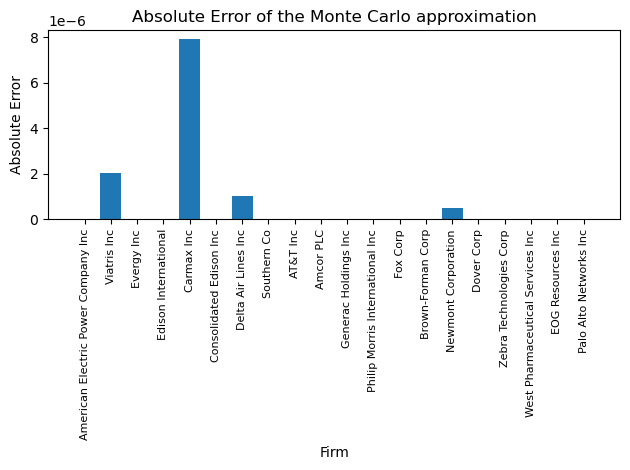

In [106]:
approx_error_df = pd.DataFrame(list(approx_error.items()), columns=['Firm', 'Absolute Error'])

approx_error_df['Firm'] = approx_error_df['Firm'].map(lambda x: rics_dict[x])

plt.figure()

plt.bar(x=approx_error_df['Firm'], height=approx_error_df['Absolute Error'])

#Rotate x-axis labels
plt.xticks(rotation=90, fontsize = 8)

#Add labels
plt.xlabel('Firm')  
plt.ylabel('Absolute Error')

plt.title('Absolute Error of the Monte Carlo approximation')

plt.tight_layout()  
plt.show()


In [107]:
#We choose as the company for the Random Walk paths plot the one with the highest probability of default.
company_for_paths = last_obs_df.index[0]
print('-'*100)

print(f'The company that will be used for the paths graph is: {rics_dict[company_for_paths]}')


----------------------------------------------------------------------------------------------------
The company that will be used for the paths graph is: Carmax Inc


We do the plot only for the company with the highest probability of default among the ones in the sample

----------------------------------------------------------------------------------------------------
Carmax Inc

Close Price                                                  82.06
Shares used to calculate Diluted EPS - Total           158707000.0
Market Capitalization                                12451343181.0
Debt - Total                                         18976741000.0
RIC                                                          KMX.N
Equity_Value                                         13023496420.0
Log_Returns                                              -0.020624
Rolling_Volatility                                         0.32529
Total_value                                          32000237420.0
A_solution                                      31256123179.656811
sigma_A_solution                                          0.135542
Leverage_Ratio                                            0.607137
Risk_Free_Rate                                                0.04
Name: 2024-12-30

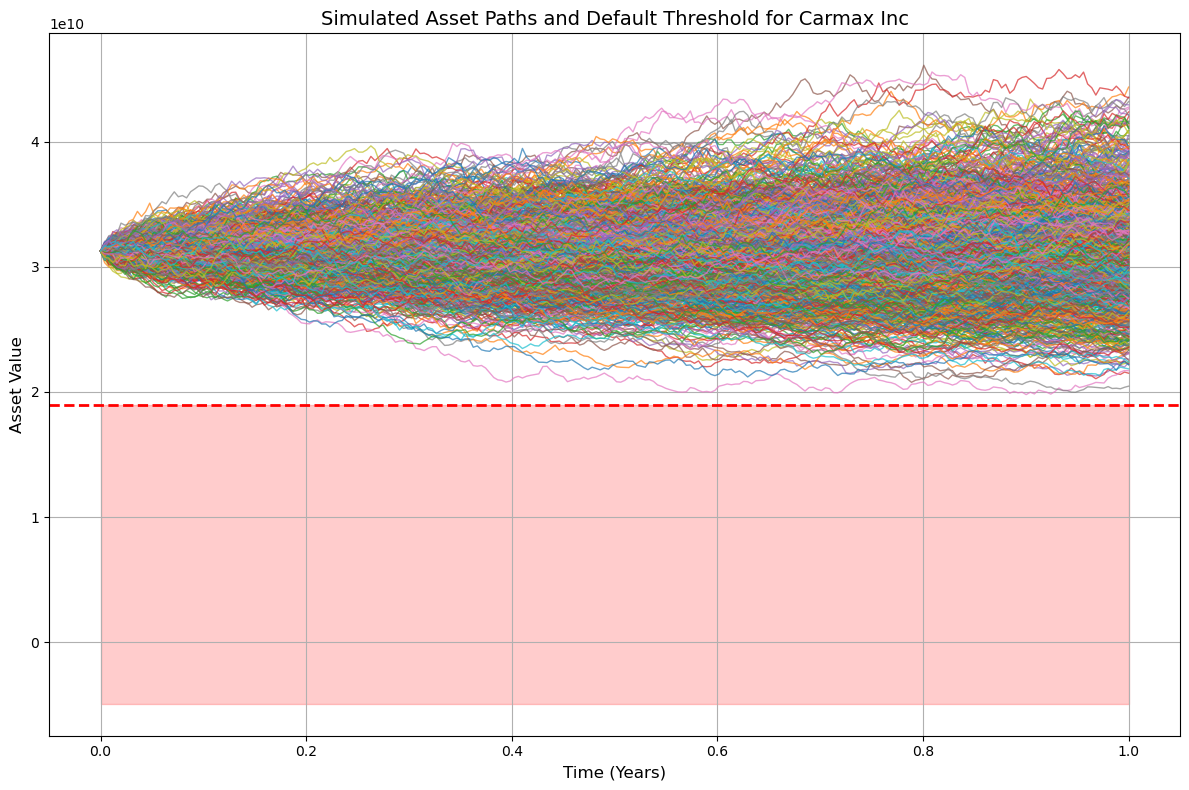

In [108]:
"""
This part of the script allows to create a plot of the simulated Random Walk paths.

In the simulations above we used the realization of the stochastic process after one year rather than simulating entire paths,
as according to the Merton's model default implementation we only care about the value of the asset's value process at the end
of the considered time horizon.
"""
ric = company_for_paths


row = df_with_solutions.loc[ric].iloc[-1]

V = row['A_solution']
sigma = row['sigma_A_solution']

K = row['Debt - Total']  # Debt
row['Risk_Free_Rate'] = 0.04
r = row['Risk_Free_Rate']

#print(V/K)

T = 1  # Time to maturity
t = 0  # Current time
M = 1_000

print('-'*100)
print(f'{rics_dict[ric]}\n')
print(row)
print('\n')

paths = af.monte_carlo_simulation_paths(V, sigma, r, T, M, N = rolling_window, K = K)


mp.plot_asset_paths_with_default(threshold=K, asset_paths= paths,
                                    time_horizon=T, instrument = rics_dict[ric])

del paths


## 5) Extensions of the Merton's model

### Merton's model with jump processes

In [109]:
importlib.reload(af)
jump_data = af.jump_dev_estimator(rics_list, 3, df_final)

jump_data = jump_data.set_index('RIC')
jump_data.index.name = None
print(jump_data)

         Jump_Std_Dev_v
AEP.OQ         0.074392
VTRS.OQ        0.126878
EVRG.OQ        0.111192
EIX.N          0.085554
KMX.N          0.138478
ED.N           0.083251
DAL.N          0.159864
SO.N           0.090757
T.N            0.074900
AMCR.N         0.071482
GNRC.N         0.162607
PM.N           0.072453
FOXA.OQ        0.085244
BFb.N          0.080883
NEM.N          0.110035
DOV.N          0.097785
ZBRA.OQ        0.116618
WST.N          0.102528
EOG.N          0.149065
PANW.OQ        0.148068


In [110]:
last_obs_df = pd.concat([last_obs_df, jump_data], axis = 1)
print(last_obs_df.head())

        Close Price Shares used to calculate Diluted EPS - Total  \
KMX.N         82.06                                  158707000.0   
VTRS.OQ       12.38                                 1206900000.0   
DAL.N         60.72                                  643000000.0   
NEM.N          37.0                                  841000000.0   
GNRC.N       154.74                                   62058387.0   

        Market Capitalization   Debt - Total      RIC       Equity_Value  \
KMX.N           12451343181.0  18976741000.0    KMX.N      13023496420.0   
VTRS.OQ        12990936920.85  18131500000.0  VTRS.OQ      14941422000.0   
DAL.N          25886533909.59  20054000000.0    DAL.N      39042960000.0   
NEM.N          32896779988.27   9436000000.0    NEM.N      31117000000.0   
GNRC.N          8044230651.48   1575217000.0   GNRC.N  9602914804.380001   

        Log_Returns Rolling_Volatility         Total_value  \
KMX.N     -0.020624            0.32529       32000237420.0   
VTRS.OQ   

In [112]:
importlib.reload(af)

pd_jump = []

for ric in rics_list:
    row = last_obs_df.loc[ric, :]
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    K = row['Debt - Total']  # Debt
    r = 0.04  # Risk-free rate
    T = 1  # Time to maturity (1 year)
    t = 0  # Current time
    M = 200_000  # Number of Monte Carlo simulations
    N = 252 * T  # Number of steps (daily)
    lam = 1  # Jump frequency
    m = 0  # Jump mean (set as 0 for simplicity)

    # Get the standard deviation of jumps (v) for the current RIC
    # v_row = jump_data[jump_data['RIC'] == ric]
    # if not v_row.empty:
    #     v = v_row['Jump_Std_Dev_v'].values[0]
    v = row['Jump_Std_Dev_v']

    print('-' * 100)
    print(f'{rics_dict[ric]}\n')
    print(row)
    print('\n')
    print(f'the jump standard deviation is: {v}')
    
    # Default probability calculations
    merton_prob = row['Default_Probability']
    print(f'\nThe probability of default according to the Merton model is: {merton_prob}\n')
    
    mc_prob_anti = row['MC_Default_Merton_PD']
    print(f'Monte Carlo approximation of DEFAULT MERTON probability of default is {mc_prob_anti}')

    # Merton with jumps (using v as the jump deviation)
    mc_prob_jumps = af.merton_jumps_default(V, K, T, M, N, lam, m, v, r, sigma)
    #mc_prob_jumps = af.merton_jumps_vectorized(V, K, T, M, N, lam, m, v, r, sigma)
    print(f'Monte Carlo JUMP probability of default is {mc_prob_jumps[2]}')
    pd_jump.append(mc_prob_jumps[2])


#last_obs_df['MC_Jump_Merton_PD'] = pd_jump
last_obs_df['MC_Jump_Merton_PD'] = pd_jump


----------------------------------------------------------------------------------------------------
American Electric Power Company Inc

Close Price                                                  92.06
Shares used to calculate Diluted EPS - Total           520206258.0
Market Capitalization                           42711651075.379997
Debt - Total                                         43179000000.0
RIC                                                         AEP.OQ
Equity_Value                                    47890188111.480003
Log_Returns                                              -0.004876
Rolling_Volatility                                        0.185153
Total_value                                     91069188111.480011
A_solution                                      89376115304.640167
sigma_A_solution                                           0.09921
Leverage_Ratio                                            0.483116
Merton_Equity_Value                             4662675353

KeyboardInterrupt: 

In [116]:
importlib.reload(af)

pd_jump = []
pd_jump_bc = []

for ric in rics_list:
    row = last_obs_df.loc[ric, :]
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    K = row['Debt - Total']  # Debt
    r = 0.04  # Risk-free rate
    T = 1  # Time to maturity (1 year)
    t = 0  # Current time
    M = 200_000  # Number of Monte Carlo simulations
    N = 252 * T  # Number of steps (daily)
    lam = 1  # Jump frequency
    m = 0  # Jump mean (set as 0 for simplicity)

    # Get the standard deviation of jumps (v) for the current RIC
    # v_row = jump_data[jump_data['RIC'] == ric]
    # if not v_row.empty:
    #     v = v_row['Jump_Std_Dev_v'].values[0]
    v = row['Jump_Std_Dev_v']

    print('-' * 100)
    print(f'{rics_dict[ric]}\n')
    print(row)
    print('\n')
    print(f'the jump standard deviation is: {v}')
    
    # Default probability calculations
    merton_prob = row['Default_Probability']
    print(f'\nThe probability of default according to the Merton model is: {merton_prob}\n')
    
    mc_prob_anti = row['MC_Default_Merton_PD']
    print(f'Monte Carlo approximation of DEFAULT MERTON probability of default is {mc_prob_anti}')

    # Merton with jumps (using v as the jump deviation)
    mc_prob_jumps = af.merton_jumps_default_with_bc(V, K, T, M, N, lam, m, v, r, sigma)
    #mc_prob_jumps = af.merton_jumps_vectorized(V, K, T, M, N, lam, m, v, r, sigma)
    print(f'Monte Carlo JUMP probability of default is {mc_prob_jumps[2]}')
    print(f'Monte Carlo JUMP with bc probability of default is {mc_prob_jumps[3]}')
    pd_jump.append(mc_prob_jumps[2])
    pd_jump_bc.append(mc_prob_jumps[3])



#last_obs_df['MC_Jump_Merton_PD'] = pd_jump
last_obs_df['MC_Jump_Merton_PD'] = pd_jump
last_obs_df['MC_Default_Merton_PD_bc'] = pd_jump_bc


----------------------------------------------------------------------------------------------------
American Electric Power Company Inc

Close Price                                                  92.06
Shares used to calculate Diluted EPS - Total           520206258.0
Market Capitalization                           42711651075.379997
Debt - Total                                         43179000000.0
RIC                                                         AEP.OQ
Equity_Value                                    47890188111.480003
Log_Returns                                              -0.004876
Rolling_Volatility                                        0.185153
Total_value                                     91069188111.480011
A_solution                                      89376115304.640167
sigma_A_solution                                           0.09921
Leverage_Ratio                                            0.483116
Merton_Equity_Value                             4662675353

### Monte Carlo simulation with jump processes

Close Price                                                  82.06
Shares used to calculate Diluted EPS - Total           158707000.0
Market Capitalization                                12451343181.0
Debt - Total                                         18976741000.0
RIC                                                          KMX.N
Equity_Value                                         13023496420.0
Log_Returns                                              -0.020624
Rolling_Volatility                                         0.32529
Total_value                                          32000237420.0
A_solution                                      31256123179.656811
sigma_A_solution                                          0.135542
Leverage_Ratio                                            0.607137
Merton_Equity_Value                             12468271322.011837
Merton_Debt_Value                               18787851857.644974
Default_Probability                                       0.00

C:\Users\franc\AppData\Local\Temp\ipykernel_40824\3919250580.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Risk_Free_Rate'] = 0.04
C:\Users\franc\AppData\Local\Temp\ipykernel_40824\3919250580.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Risk_Free_Rate'] = 0.04


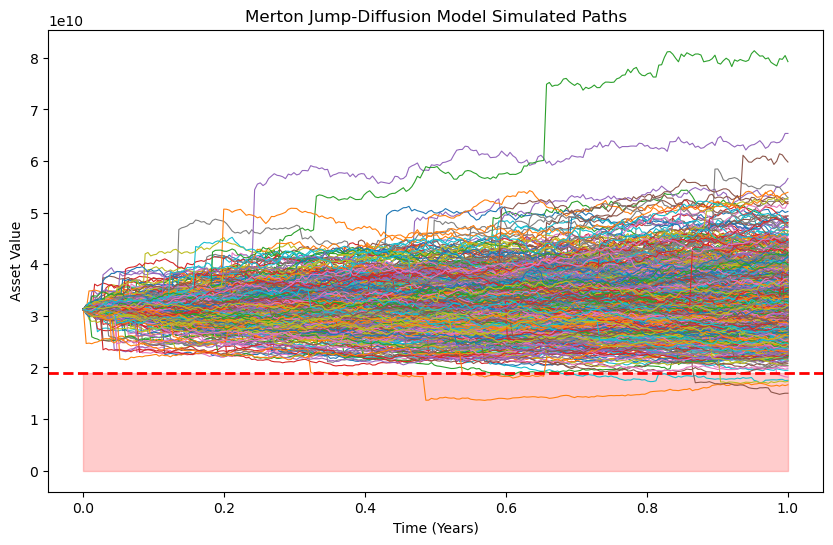

In [117]:
from plotting_functions import merton_jumps_plot


"""
This part of the script allows to create a plot of the simulated Random Walk paths.

In the simulations above we used the realization of the stochastic process after one year rather than simulating entire paths,
as according to the Merton's model default implementation we only care about the value of the asset's value process at the end
of the considered time horizon.
"""
ric = company_for_paths


row = last_obs_df.loc[ric, :]
print(row)
V = row['A_solution']
sigma = row['sigma_A_solution']

K = row['Debt - Total']  # Debt
row['Risk_Free_Rate'] = 0.04
r = row['Risk_Free_Rate']

#print(V/K)

T = 1  # Time to maturity
t = 0  # Current time
M = 1_000
m = 0
v = row['Jump_Std_Dev_v']
lam = 1
N = 252 * T

print('-'*100)
print(f'{rics_dict[ric]}\n')
print(row)
print('\n')
print(f"v is {v}")
print(f"V is {V}")
print(m)
print()

merton_jumps_plot(V, sigma, r, T, M, N, lam, m, v, K)


### Comparison between the Merton's default implementation and with jump processes

In [119]:
last_obs_df[['MC_Jump_Merton_PD','MC_Default_Merton_PD','MC_Default_Merton_PD_bc']].describe()

MC_Jump_Merton_PD  MC_Default_Merton_PD  MC_Default_Merton_PD_bc
count          20.000000             20.000000                20.000000
mean            0.000397              0.000008                 0.000664
std             0.001354              0.000032                 0.002268
min             0.000000              0.000000                 0.000000
25%             0.000000              0.000000                 0.000000
50%             0.000000              0.000000                 0.000000
75%             0.000006              0.000000                 0.000008
max             0.005900              0.000143                 0.009875

In [120]:
# Ensure the data is non-negative
jump_merton_pd = last_obs_df['MC_Jump_Merton_PD']
default_merton_pd = last_obs_df['MC_Default_Merton_PD']
jump_merton_pd_cox = last_obs_df['MC_Default_Merton_PD_bc']

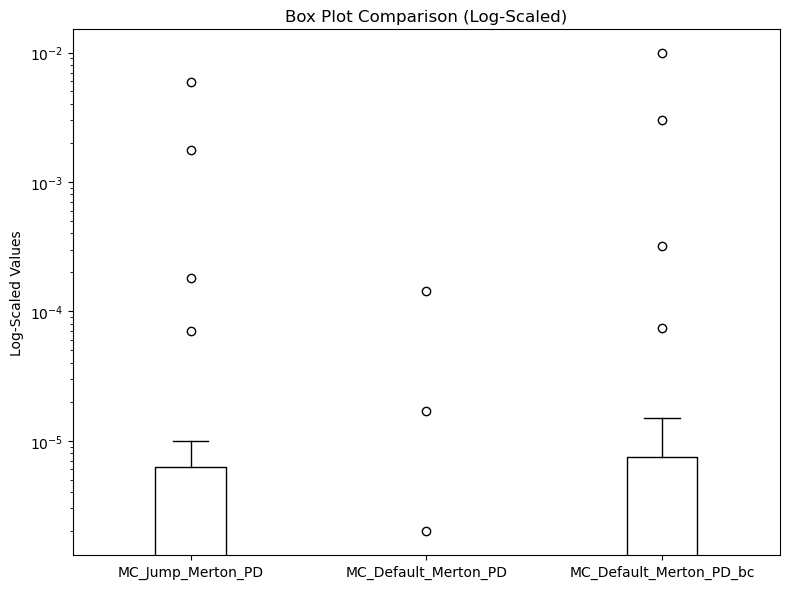

In [121]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.boxplot([jump_merton_pd, default_merton_pd, jump_merton_pd_cox], labels=['MC_Jump_Merton_PD', 'MC_Default_Merton_PD', 'MC_Default_Merton_PD_bc'])
plt.yscale('log')
plt.ylabel('Log-Scaled Values')
plt.title('Box Plot Comparison (Log-Scaled)')
plt.tight_layout()
plt.show()


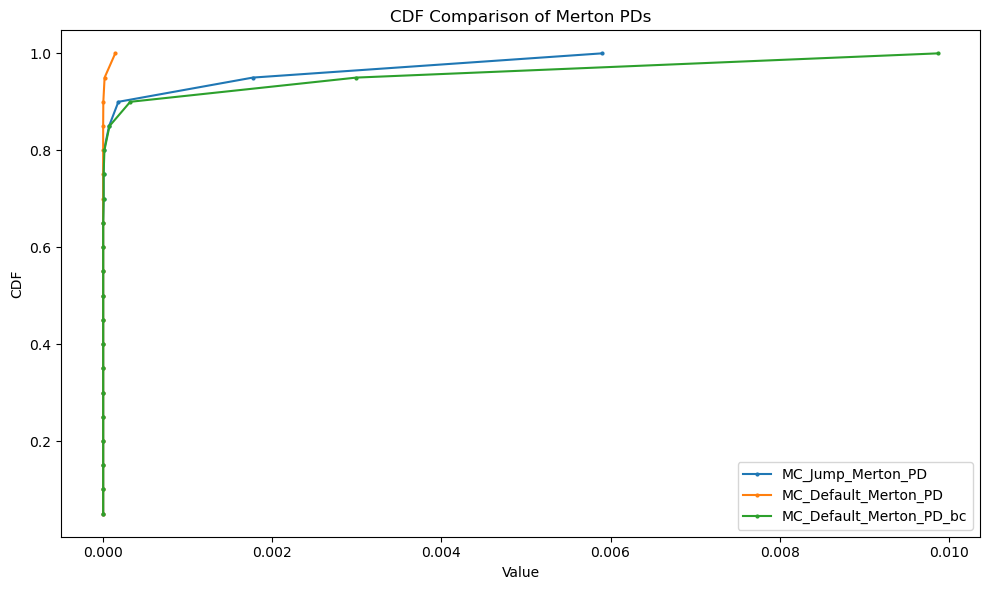

In [124]:
import numpy as np

jump_sorted = np.sort(jump_merton_pd)
default_sorted = np.sort(default_merton_pd)

jump_sorted_bc = np.sort(jump_merton_pd_cox)

jump_cdf = np.arange(1, len(jump_sorted) + 1) / len(jump_sorted)
jump_cdf_bc = np.arange(1, len(jump_sorted_bc) + 1) / len(jump_sorted_bc)
default_cdf = np.arange(1, len(default_sorted) + 1) / len(default_sorted)

plt.figure(figsize=(10, 6))
plt.plot(jump_sorted, jump_cdf, label='MC_Jump_Merton_PD', marker='o', markersize=2)
plt.plot(default_sorted, default_cdf, label='MC_Default_Merton_PD', marker='o', markersize=2)
plt.plot(jump_sorted_bc, jump_cdf_bc, label='MC_Default_Merton_PD_bc', marker='o', markersize=2)
plt.xlabel('Value')
plt.ylabel('CDF')
plt.title('CDF Comparison of Merton PDs')
plt.legend()
plt.tight_layout()
plt.show()


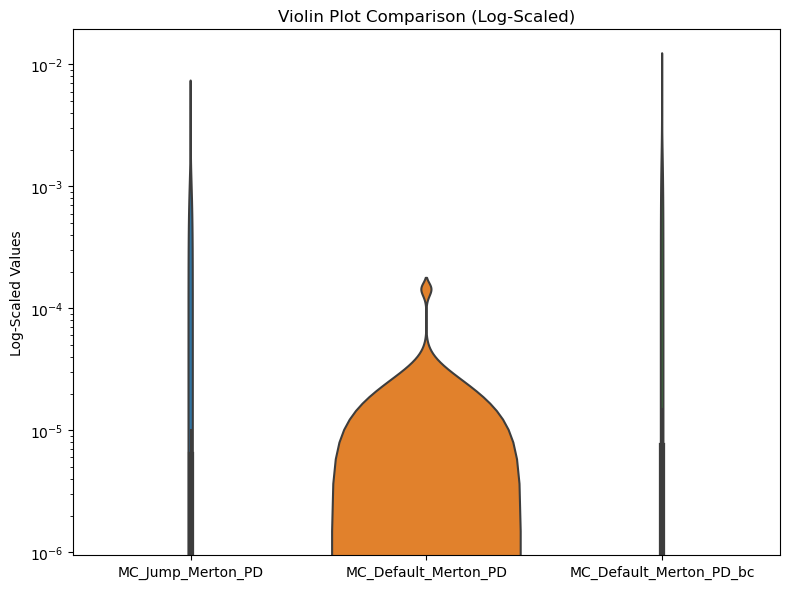

In [125]:
import seaborn as sns

data = last_obs_df[['MC_Jump_Merton_PD', 'MC_Default_Merton_PD','MC_Default_Merton_PD_bc']]
plt.figure(figsize=(8, 6))
sns.violinplot(data=data)
plt.yscale('log')
plt.ylabel('Log-Scaled Values')
plt.title('Violin Plot Comparison (Log-Scaled)')
plt.tight_layout()
plt.show()


## Numerical study

In [43]:
importlib.reload(dr)
bond_data = pd.DataFrame()

for ric in rics_list:
    # Define the fields you want to retrieve
    
    
    fields_2 = ['TR.MIDYIELD', #Yield corresponding to the mid-price 
                'TR.FiMaturityDate', #Maturity date
                'TR.FiIsAssetActive', #Binary value of whether the given bond is still actively negotiated
              'TR.FiInstrumentTypeDescription', #Type of instrument
              'TR.FiCouponType', #Finding the type of coupons
              'TR.GovernmentSpreadAnalytics',
              'TR.FiParentImmedLongName' #To check whether the bond issued has been issued by a subsidiary.
              ]

    
    df = dr.single_company_bond_data(ric, fields_2, start_date)


    if not df.empty:
        
        bond_data = pd.concat([bond_data, df])



In [ ]:
print(f'The total bonds are: {bond_data.shape[0]}')

bond_data_filtered = bond_data[
    bond_data.apply(
        lambda row: rics_dict.get(row['RIC'], '').lower() == row['Parent Immed Long Name'].lower(),
        axis=1
    )
]


print(f'The bonds directly issued by the companies are: {bond_data_filtered.shape[0]}\n{bond_data.shape[0] - bond_data_filtered.shape[0]} less.')

bond_data = bond_data_filtered

The total bonds are: 797
The bonds directly issued by the companies are: 681
116 less.


In [ ]:
#Removing not actively negotiated bonds
bond_data = bond_data[bond_data['Is Asset Active'] == 'Y']

#Sorting by maturity date
bond_data = bond_data.sort_values(by = 'Maturity Date')

#Keeping only bonds while removing commercial papers and debenteurs
bond_data = bond_data[bond_data['Instrument Type Description'] == 'Note']

#Converting maturity dates to datetime objects
bond_data['Maturity Date'] = bond_data['Maturity Date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))

#Keeping only Fixed Rate Plain Vanilla Coupon structured bonds
bond_data= bond_data[bond_data['Coupon Type'] == 'FXPV']

bond_data.dropna(how ='any')

Instrument  Mid Yield Maturity Date Is Asset Active  \
66   US010392FN37     4.8027    2025-04-01               Y   
4    US26875PAM32     0.2174    2025-04-01               Y   
2    US35137LAM72    5.07115    2025-04-07               Y   
6    US115637AS96     4.8008    2025-04-15               Y   
10   US281020AR84    5.06895    2025-04-15               Y   
..            ...        ...           ...             ...   
63   US00206RKB77      5.902    2060-06-01               Y   
55   US00206RKF81      5.847    2061-02-01               Y   
112  US00206RHC97      7.682    2095-12-01               Y   
109  US00206RHB15      7.297    2095-12-15               Y   
111  US00206RHD70      6.547    2097-07-15               Y   

    Instrument Type Description Coupon Type  Government Spread  \
66                         Note        FXPV          48.378358   
4                          Note        FXPV        -325.485703   
2                          Note        FXPV          49.409649   
6                          Note        FXPV          63.775716   
10                         Note        FXPV          76.800609   
..                          ...         ...                ...   
63                         Note        FXPV          120.74219   
55                         Note        FXPV         107.341802   
112                        Note        FXPV         290.829661   
109                        Note        FXPV         254.341769   
111                        Note        FXPV         177.340955   

    Parent Immed Long Name      RIC  
66             SOUTHERN CO     SO.N  
4        EOG RESOURCES INC    EOG.N  
2                 FOX CORP  FOXA.OQ  
6        BROWN-FORMAN CORP    BFb.N  
10    EDISON INTERNATIONAL    EIX.N  
..                     ...      ...  
63                AT&T INC      T.N  
55                AT&T INC      T.N  
112               AT&T INC      T.N  
109               AT&T INC      T.N  
111               AT&T INC      T.N  

[442 rows x 9 columns]

In [46]:
bond_data.isna().sum()

Instrument                     0
Mid Yield                      0
Maturity Date                  0
Is Asset Active                0
Instrument Type Description    0
Coupon Type                    0
Government Spread              0
Parent Immed Long Name         0
RIC                            0
dtype: int64

In [ ]:
for idx, ric in enumerate(rics_list):

    number = bond_data[bond_data['RIC'] == f'{rics_list[idx]}'].shape[0]
    print(f'{rics_dict[ric]} has issued: {number} or {(number/ bond_data.shape[0]*100):.2f}%')

American Electric Power Company Inc has issued: 74 or 16.74%
Viatris Inc has issued: 7 or 1.58%
Evergy Inc has issued: 8 or 1.81%
Edison International has issued: 10 or 2.26%
Carmax Inc has issued: 0 or 0.00%
Consolidated Edison Inc has issued: 2 or 0.45%
Delta Air Lines Inc has issued: 5 or 1.13%
Southern Co has issued: 63 or 14.25%
AT&T Inc has issued: 158 or 35.75%
Amcor PLC has issued: 14 or 3.17%
Generac Holdings Inc has issued: 0 or 0.00%
Philip Morris International Inc has issued: 44 or 9.95%
Fox Corp has issued: 12 or 2.71%
Brown-Forman Corp has issued: 7 or 1.58%
Newmont Corporation has issued: 22 or 4.98%
Dover Corp has issued: 6 or 1.36%
Zebra Technologies Corp has issued: 2 or 0.45%
West Pharmaceutical Services Inc has issued: 0 or 0.00%
EOG Resources Inc has issued: 8 or 1.81%
Palo Alto Networks Inc has issued: 0 or 0.00%


In [48]:
def map_date_to_number(date, start_date, total_days=252):
    # Parse the input dates
    #input_date = datetime.strptime(date_str, "%Y-%m-%d")
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = start_date + relativedelta(years=1)
    
    # Calculate the total number of days in the range
    total_days_range = (end_date - start_date).days
    
    # Ensure input_date is datetime object
    delta_days = (date - start_date).days  # Days from the start_date
    
    # Linear mapping (extrapolate if out of range).
    mapped_value = total_days * delta_days / total_days_range
    
    return mapped_value / rolling_window

In [49]:
bond_data['Years to Maturity'] = bond_data['Maturity Date'].map(lambda x: map_date_to_number(x, start_date, total_days = rolling_window))

In [ ]:
last_obs_df

Close Price Shares used to calculate Diluted EPS - Total  \
KMX.N         82.06                                  158707000.0   
VTRS.OQ       12.38                                 1206900000.0   
DAL.N         60.72                                  643000000.0   
NEM.N          37.0                                  841000000.0   
GNRC.N       154.74                                   62058387.0   
T.N           22.61                                 7258000000.0   
AMCR.N         9.34                                 1441000000.0   
EIX.N         79.68                                  385000000.0   
AEP.OQ        92.06                                  520206258.0   
ZBRA.OQ      383.85                                   51710962.0   
ED.N          89.16                                  349300000.0   
BFb.N         37.72                                  477220000.0   
EVRG.OQ       61.52                                  230500000.0   
SO.N          82.38                                 1098000000.0   
FOXA.OQ       48.84                                  480000000.0   
PANW.OQ       184.2                                  354000000.0   
PM.N         120.01                                 1553000000.0   
DOV.N        186.32                                  140599000.0   
WST.N        328.82                                   75300000.0   
EOG.N        120.58                                  584000000.0   

        Market Capitalization    Debt - Total      RIC        Equity_Value  \
KMX.N           12451343181.0   18976741000.0    KMX.N       13023496420.0   
VTRS.OQ        12990936920.85   18131500000.0  VTRS.OQ       14941422000.0   
DAL.N          25886533909.59   20054000000.0    DAL.N       39042960000.0   
NEM.N          32896779988.27    9436000000.0    NEM.N       31117000000.0   
GNRC.N          8044230651.48    1575217000.0   GNRC.N   9602914804.380001   
T.N            119977000000.0  137331000000.0      T.N      164103380000.0   
AMCR.N     14135456613.360001    6699000000.0   AMCR.N       13458940000.0   
EIX.N      27421327292.369999   34090000000.0    EIX.N  30676800000.000004   
AEP.OQ     42711651075.379997   43179000000.0   AEP.OQ  47890188111.480003   
ZBRA.OQ    14032315032.120001    2220000000.0  ZBRA.OQ  19849252763.700001   
ED.N       31377698527.450001   24467000000.0     ED.N       31143588000.0   
BFb.N      22820225310.119999    3100000000.0    BFb.N       18000738400.0   
EVRG.OQ    11990452438.799999   13201800000.0  EVRG.OQ       14180360000.0   
SO.N       76469126119.479996   62000000000.0     SO.N       90453240000.0   
FOXA.OQ        15487934457.34    7197000000.0  FOXA.OQ       23443200000.0   
PANW.OQ        105147574000.0     963900000.0  PANW.OQ  65206799999.999992   
PM.N      146050355633.279999   47909000000.0     PM.N      186375530000.0   
DOV.N      21516503048.639999    3469008000.0    DOV.N       26196405680.0   
WST.N      26053242600.400002     206800000.0    WST.N       24760146000.0   
EOG.N      70424455613.100006    3799000000.0    EOG.N       70418720000.0   

        Log_Returns Rolling_Volatility         Total_value  \
KMX.N     -0.020624            0.32529       32000237420.0   
VTRS.OQ   -0.008045           0.295775       33072922000.0   
DAL.N     -0.008854           0.327727       59096960000.0   
NEM.N     -0.022449           0.370962       40553000000.0   
GNRC.N    -0.005992           0.356244  11178131804.380001   
T.N       -0.010996           0.206243      301434380000.0   
AMCR.N     -0.01065           0.222089       20157940000.0   
EIX.N      -0.00138           0.175841       64766800000.0   
AEP.OQ    -0.004876           0.185153  91069188111.480011   
ZBRA.OQ   -0.013507           0.304162  22069252763.700001   
ED.N      -0.004476           0.168118       55610588000.0   
BFb.N     -0.028745           0.263118       21100738400.0   
EVRG.OQ   -0.002922           0.158659       27382160000.0   
SO.N      -0.009183           0.167043      152453240000.0   
FOXA.OQ   

### Computing the Merton's credit spread for the bonds and comparing it to the market's

In [ ]:
bond_data

Instrument  Mid Yield Maturity Date Is Asset Active  \
66   US010392FN37     4.8027    2025-04-01               Y   
4    US26875PAM32     0.2174    2025-04-01               Y   
2    US35137LAM72    5.07115    2025-04-07               Y   
6    US115637AS96     4.8008    2025-04-15               Y   
10   US281020AR84    5.06895    2025-04-15               Y   
..            ...        ...           ...             ...   
63   US00206RKB77      5.902    2060-06-01               Y   
55   US00206RKF81      5.847    2061-02-01               Y   
112  US00206RHC97      7.682    2095-12-01               Y   
109  US00206RHB15      7.297    2095-12-15               Y   
111  US00206RHD70      6.547    2097-07-15               Y   

    Instrument Type Description Coupon Type  Government Spread  \
66                         Note        FXPV          48.378358   
4                          Note        FXPV        -325.485703   
2                          Note        FXPV          49.409649   
6                          Note        FXPV          63.775716   
10                         Note        FXPV          76.800609   
..                          ...         ...                ...   
63                         Note        FXPV          120.74219   
55                         Note        FXPV         107.341802   
112                        Note        FXPV         290.829661   
109                        Note        FXPV         254.341769   
111                        Note        FXPV         177.340955   

    Parent Immed Long Name      RIC  Years to Maturity  
66             SOUTHERN CO     SO.N           0.252055  
4        EOG RESOURCES INC    EOG.N           0.252055  
2                 FOX CORP  FOXA.OQ           0.268493  
6        BROWN-FORMAN CORP    BFb.N           0.290411  
10    EDISON INTERNATIONAL    EIX.N           0.290411  
..                     ...      ...                ...  
63                AT&T INC      T.N          35.443836  
55                AT&T INC      T.N          36.115068  
112               AT&T INC      T.N          70.967123  
109               AT&T INC      T.N          71.005479  
111               AT&T INC      T.N          72.589041  

[442 rows x 10 columns]

In [52]:
bond_data = bond_data.dropna(how ='any')

In [53]:
bond_data['Government Spread']

66      48.378358
4     -325.485703
2       49.409649
6       63.775716
10      76.800609
          ...    
63      120.74219
55     107.341802
112    290.829661
109    254.341769
111    177.340955
Name: Government Spread, Length: 442, dtype: Float64

In [ ]:
maturities = []
merton_spreads = []
market_spreads = []
rics = []

for idx in range(bond_data.shape[0]):
    print('-'*100)
    bond = bond_data.iloc[idx]
    
    
    ric = bond['RIC']
    rics.append(ric)

    row = last_obs_df.loc[ric,:]
    # print(f'{rics_dict[ric]}')
    # print(bond)
    # print(f'\n{row}')
    
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    K = row['Debt - Total']  

#    row['Risk_Free_Rate'] = 0.01
    r = bond['Mid Yield'] - (bond['Government Spread']/100)
    #r = 0.04
    #print(r)
    #Time to maturity and current time
    T = bond['Years to Maturity']  
    maturities.append(T)
    #print(T)
    t = 0  
    credit_spread = af.credit_spread_model(V, K, sigma, r, T, t)
    merton_spreads.append(credit_spread)

    print(f'Merton Credit Spread: {credit_spread}')

    market_spread = bond['Government Spread']
    market_spreads.append(market_spread/10000)
    print(f'Market Spread: {market_spread/100}\n')
    

    

----------------------------------------------------------------------------------------------------
Merton Credit Spread: -0.0
Market Spread: 0.48378358

----------------------------------------------------------------------------------------------------
Merton Credit Spread: -0.0
Market Spread: -3.25485703

----------------------------------------------------------------------------------------------------
Merton Credit Spread: -0.0
Market Spread: 0.49409649

----------------------------------------------------------------------------------------------------
Merton Credit Spread: -0.0
Market Spread: 0.63775716

----------------------------------------------------------------------------------------------------
Merton Credit Spread: -0.0
Market Spread: 0.76800609

----------------------------------------------------------------------------------------------------
Merton Credit Spread: -0.0
Market Spread: 1.72621679

---------------------------------------------------------------------

In [55]:
credit_spread_comparison_df = pd.DataFrame()
credit_spread_comparison_df['Maturity'] = maturities
credit_spread_comparison_df['Merton Credit Spread'] = merton_spreads
credit_spread_comparison_df['Market Credit Spread'] = market_spreads
credit_spread_comparison_df['RIC'] = rics

In [56]:
merton_spreads

[-0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,

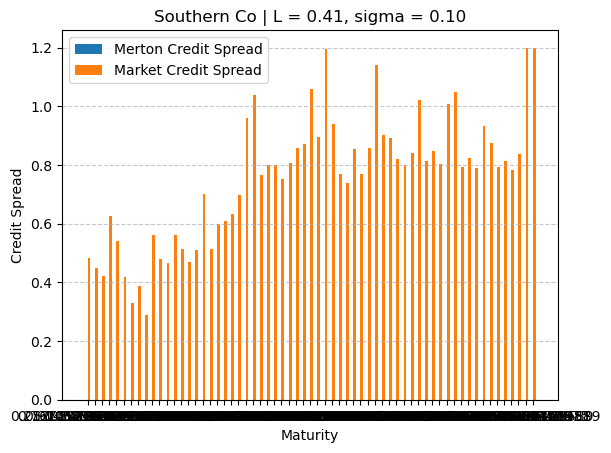

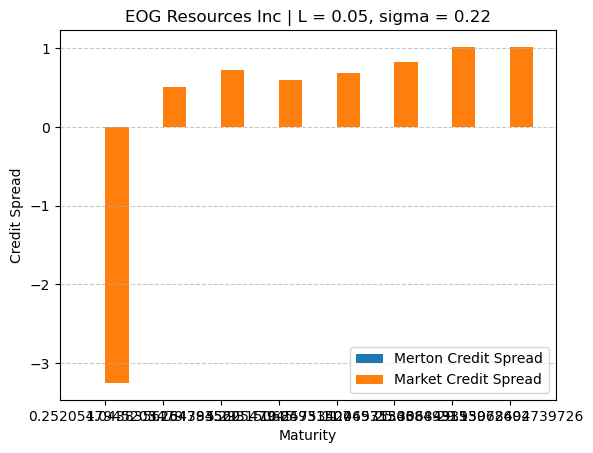

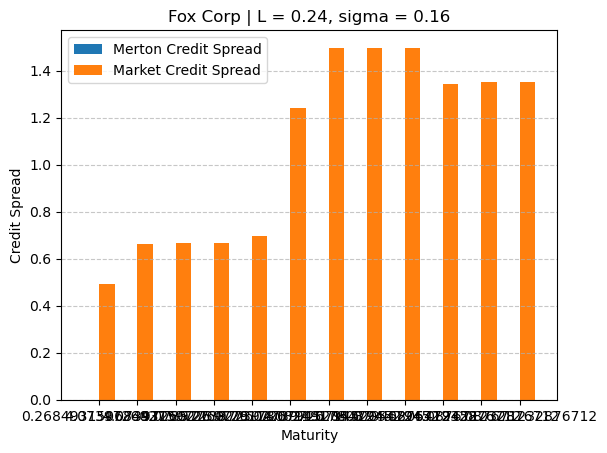

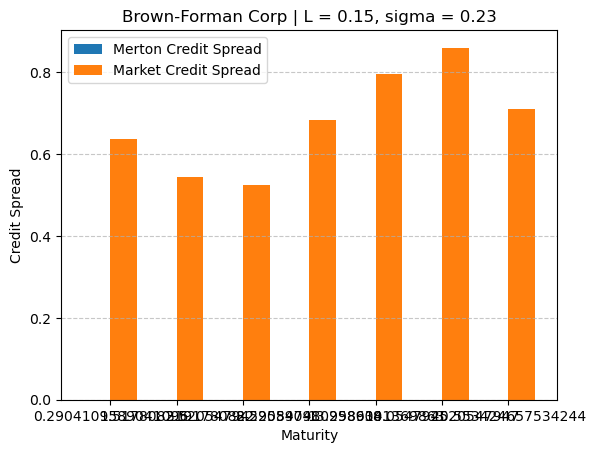

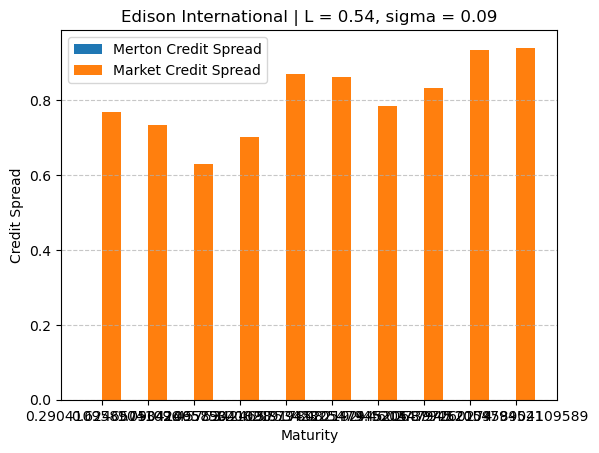

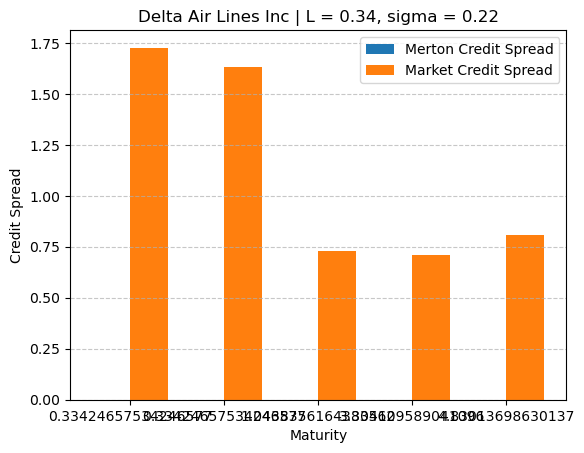

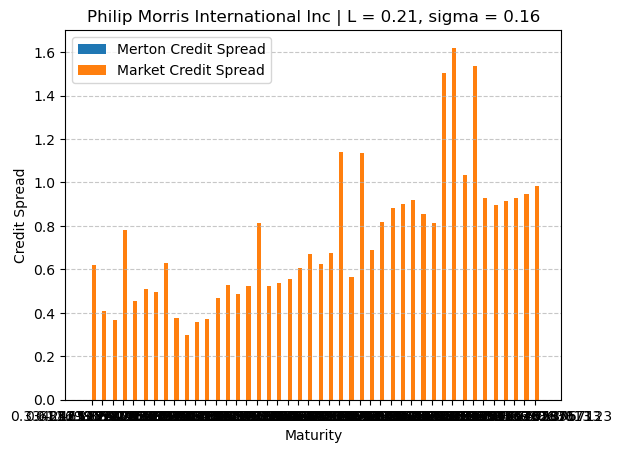

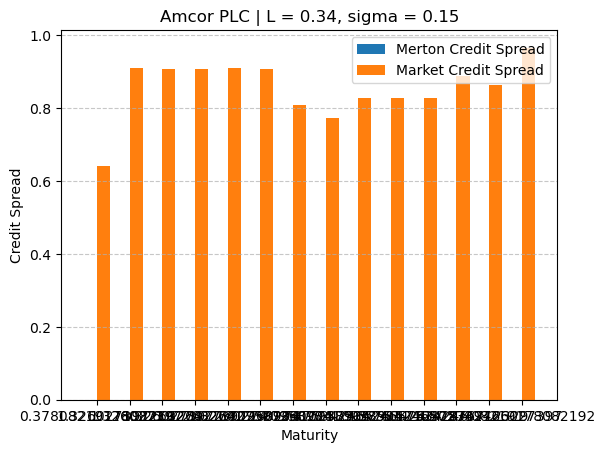

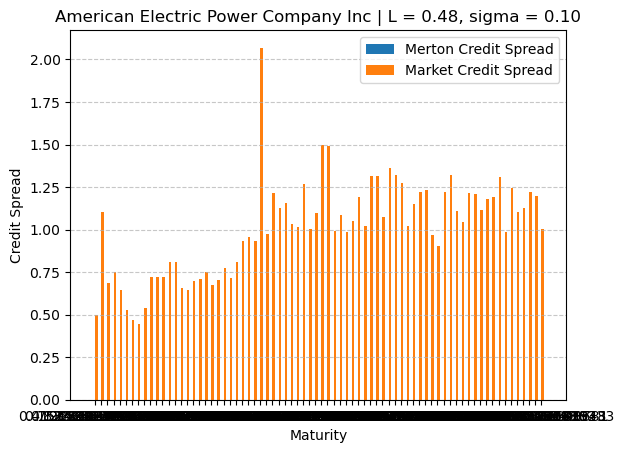

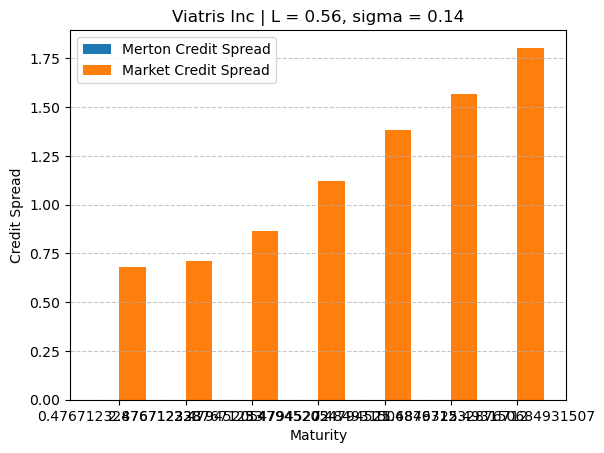

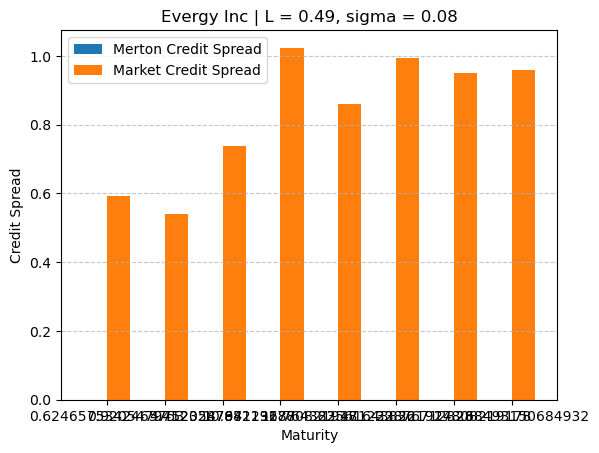

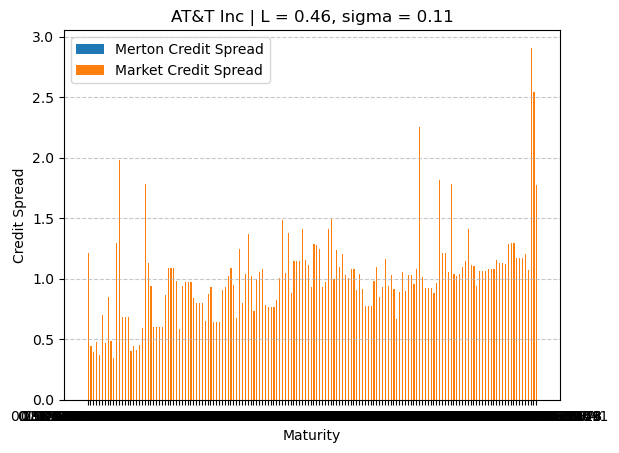

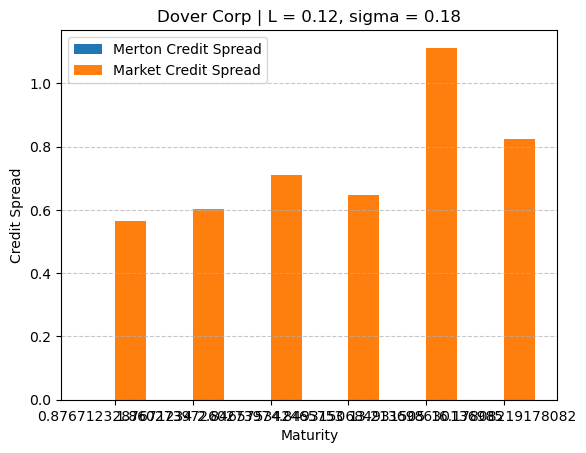

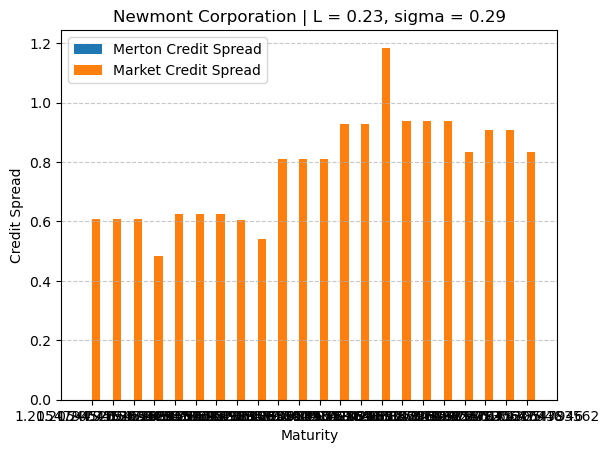

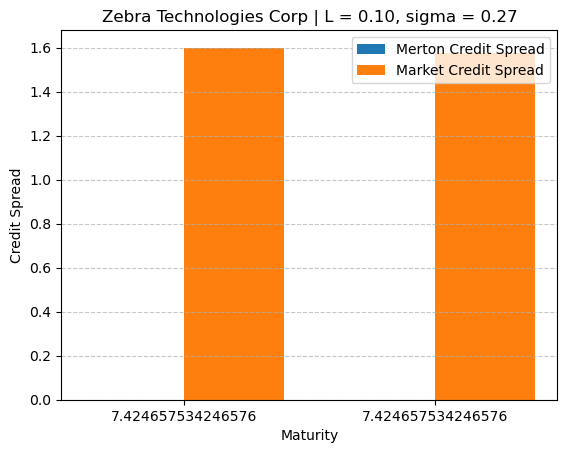

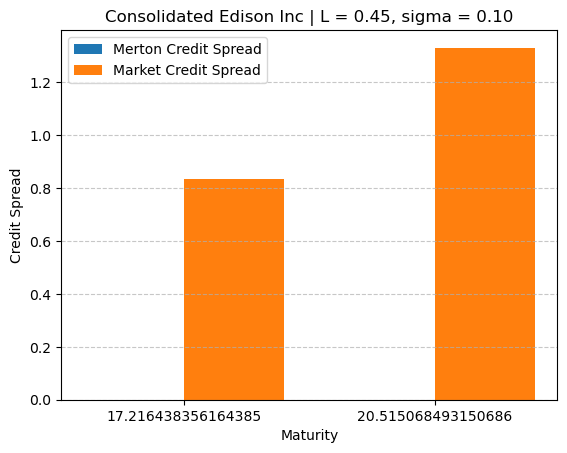

In [ ]:
for ric in credit_spread_comparison_df['RIC'].unique():

    plt.figure()

    row = last_obs_df.loc[ric,:]
    leverage_ratio = row['Leverage_Ratio']
    sigma = row['sigma_A_solution']
    plt.title(f'{rics_dict[ric]} | L = {leverage_ratio:.2f}, sigma = {sigma:.2f}')
    df_to_plot = credit_spread_comparison_df[credit_spread_comparison_df['RIC'] == ric]
    
    mats = df_to_plot['Maturity']
    mrt_spreads = df_to_plot['Merton Credit Spread']
    mkt_spreads = df_to_plot['Market Credit Spread']

    # Generate positions for side-by-side bars
    x = np.arange(len(mats))
    width = 0.4  # Width of the bars

    mkt_spreads = [i* 100 for i in mkt_spreads]
    mrt_spreads = [i*100 for i in mrt_spreads]

    # Plot bars side by side
    plt.bar(x - width / 2, mrt_spreads, width, label='Merton Credit Spread')
    plt.bar(x + width / 2, mkt_spreads, width, label='Market Credit Spread')

    # Add labels, legend, and grid
    plt.xticks(x, mats)
    plt.xlabel('Maturity')
    plt.ylabel('Credit Spread')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [58]:
credit_spread_comparison_df[credit_spread_comparison_df['RIC'] == ric]

Maturity  Merton Credit Spread  Market Credit Spread   RIC
327  17.216438                  -0.0              0.008337  ED.N
354  20.515068                  -0.0              0.013308  ED.N

## **TO-DO: Comparison between model's credit spread and real-world observed credit spreads**

#### Ratings of S&P 500

In [ ]:
ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI)',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI,Sdate=-10Y)'])
print(ratings_data.head())

ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating'])
print(ratings_data.head())

  Instrument        Company Common Name  Issuer Rating  Issuer Rating
0    POOL.OQ                  Pool Corp           <NA>           <NA>
1    CHRW.OQ  CH Robinson Worldwide Inc           <NA>           <NA>
2      AJG.N  Arthur J. Gallagher & Co.           <NA>           <NA>
3      CNP.N     CenterPoint Energy Inc           <NA>           <NA>
4     AMCR.N                  Amcor PLC           <NA>           <NA>
  Instrument        Company Common Name Issuer Rating
0    POOL.OQ                  Pool Corp           A1+
1    CHRW.OQ  CH Robinson Worldwide Inc           A1+
2      AJG.N  Arthur J. Gallagher & Co.          Baa2
3      CNP.N     CenterPoint Energy Inc          Baa3
4     AMCR.N                  Amcor PLC          Baa2


In [ ]:
ratings_data['Issuer Rating'].value_counts()

Issuer Rating
Baa2            51
Baa1            49
A1+             39
A1              39
                35
P-2             31
A2              25
Baa3            24
A3              20
NR              19
BBB             17
A               13
P-1             12
BBB+            11
Ba1             11
Aa3             10
WR               9
BBB-             9
A-               7
F1               6
WD               6
Ba2              6
A+               5
Discontinued     5
Aa2              4
BB               4
F2               4
BB+              4
P-3              3
F3               2
B-               2
Ba3              2
B1               2
AA-              2
B                2
BB-              2
LGD2 - 20%       1
LGD4 - 54%       1
(P)Baa3          1
LGD4 - 68%       1
LGD5 - 74%       1
LGD5 - 81%       1
(P)A2            1
B+               1
AA               1
(P)Baa2          1
Aaa              1
Name: count, dtype: Int64

In [61]:
ratings_data[ratings_data['Issuer Rating'] == 'B1']

Instrument        Company Common Name Issuer Rating
63       DAY.N               Dayforce Inc            B1
346     CZR.OQ  Caesars Entertainment Inc            B1

In [62]:
df_final.to_pickle("df_final.pkl")
last_obs_df.to_pickle("last_obs_df.pkl")


In [63]:
bond_data.to_pickle("bond_data.pkl")